In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

# functions
# read_colvar function which sorts colvar for unique entries from the back (i.e., second entry retained)
def read_colvar(colvar_file):

    data = np.loadtxt(colvar_file)
    # inverse order
    data = data[::-1]
    unique_idxs = np.array(np.unique(data[:,0], return_index=True)[1]).astype(int)[::-1] # find unique indices, first occurences
    data = data[unique_idxs]
    # original order
    data = data[::-1]

    return data


def sampling_efficiency(logw, axis=None):
    from scipy.special import logsumexp

    return np.exp(2 * logsumexp(logw, axis=axis) - logsumexp(2 * logw, axis=axis) - np.log(np.size(logw, axis=axis)))


def calcESS(logw, norm=False):
    from scipy.special import logsumexp

    if norm:
        shift = np.log(len(logw))
    else:
        shift = 0
    return np.exp(2 * logsumexp(logw) - logsumexp(2 * logw) - shift)

# Function to calculate helical fraction
def helical_fraction(ss_line):
    helix_chars = {'H', 'G', 'I'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate helical fraction
def betastrand_fraction(ss_line):
    beta_chars = {'E', 'B'}
    n_residues = len(ss_line)
    n_beta = sum(1 for c in ss_line if c in beta_chars)
    return n_beta / n_residues

# function to calculate PPII content
def PPII_fraction(ss_line):
    helix_chars = {'P'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate per-residue helicity per frame
def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

# Function to calculate per-residue PPII per frame
def dssp_to_PPII(dssp_lines):
    """
    Convert DSSP strings into a binary PPII matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('P'), 0 = non-helix.
    """
    helix_codes = {'P'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

# Function to calculate per-residue beta strand per frame
def dssp_to_strand(dssp_lines):
    """
    Convert DSSP strings into a binary strand matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = beta strand ('E', 'B'), 0 = non-strand.
    """
    strand_codes = {'E', 'B'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    strand = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        strand[i, :] = [1 if c in strand_codes else 0 for c in line]
    
    return strand


output_path = './plots_fragmentACTR/'
prod_name = '300K'
path = '../OPES_multiT/fragment_helix_ACTR/NEW_PRODUCTION_OPES_multiT_300K_noHMR/alldata/'

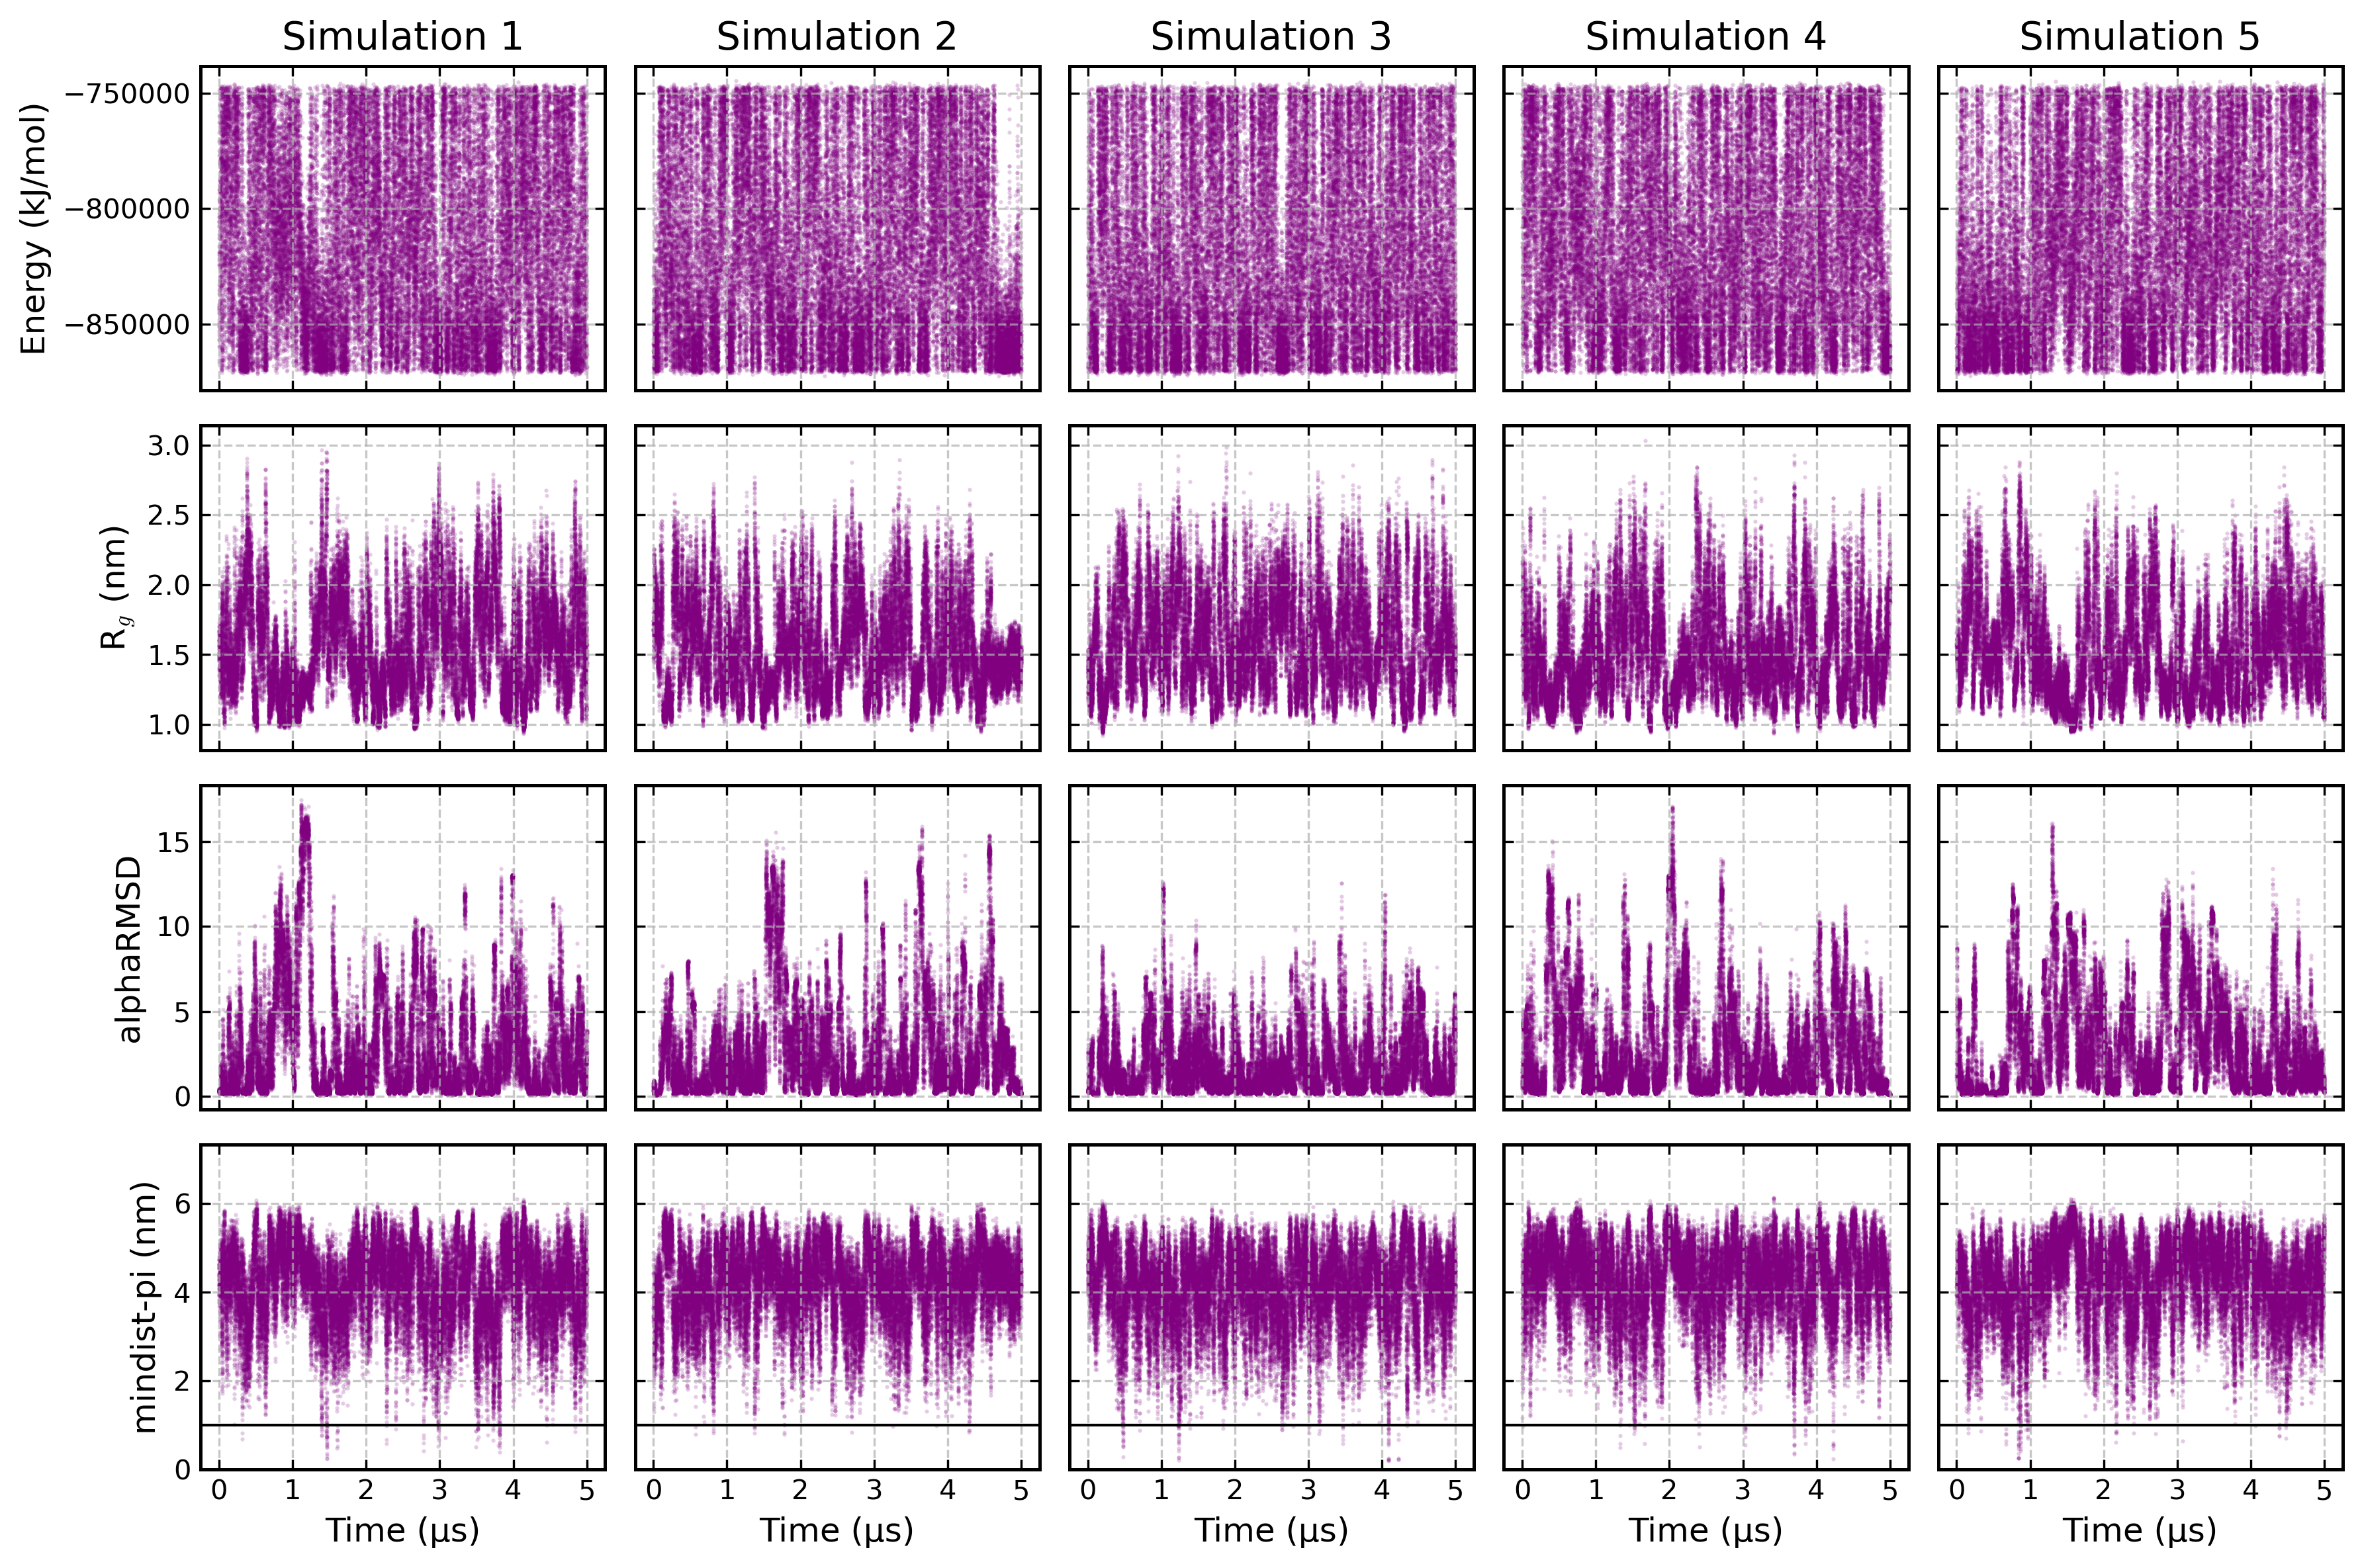

In [4]:
# plot all time evolutions of potential energy, rg, alpharmsd, and mindist


nsims = 5
descriptors = ["Potential energy", "R$_g$ (nm)", "alphaRMSD", "Min. periodic distance (nm)"]

fig, axes = plt.subplots(
    nrows=4, ncols=nsims, figsize=(12, 8), sharex="col", sharey="row"
)

for sim in range(nsims):
    # Load data
    data = read_colvar(path+f'COLVAR.{sim}')[::50] # subsample
    CVS = np.loadtxt(path+f'CVS_DATA.{sim}')[::10] # subsample
    mindist = np.loadtxt(path+f'../mindist_data/mindist{sim}.xvg',skiprows=29)[::10] # subsample

    # Time arrays in μs
    time_data = data[:, 0] / 1e6        # ps -> μs
    # Apply cutoff at 5 µs
    mask_data = time_data <= 5.0 
    time_data = time_data[mask_data]
    data = data[mask_data]
    CVS = CVS[mask_data]   
    mindist = mindist[mask_data]   

    # Row 1: Potential energy
    axes[0, sim].scatter(time_data, data[:, 1], s=0.25, alpha=0.2, color='purple', rasterized=True)
    axes[0, sim].set_xticks([0, 1, 2, 3, 4, 5])
    axes[0, sim].set_xticklabels([0, 1, 2, 3, 4, 5])    
    if sim == 0:
        axes[0, sim].set_ylabel("Energy (kJ/mol)")
        

    # Row 2: Rg
    axes[1, sim].scatter(time_data, CVS[:, 1], s=0.25, alpha=0.2, color = 'purple', rasterized=True)
    axes[1, sim].set_xticks([0, 1, 2, 3, 4, 5])
    axes[1, sim].set_xticklabels([0, 1, 2, 3, 4, 5])   
    if sim == 0:
        axes[1, sim].set_ylabel("R$_g$ (nm)")

    # Row 3: alphaRMSD
    axes[2, sim].scatter(time_data, CVS[:, 2], s=0.25, alpha=0.2, color = 'purple', rasterized=True)
    axes[2, sim].set_xticks([0, 1, 2, 3, 4, 5])
    axes[2, sim].set_xticklabels([0, 1, 2, 3, 4, 5])   
    if sim == 0:
        axes[2, sim].set_ylabel("alphaRMSD")

    # Row 4: mindist
    axes[3, sim].scatter(time_data, mindist[:, 1], s=0.25, alpha=0.2, color = 'purple', rasterized=True)
    axes[3, sim].set_xticks([0, 1, 2, 3, 4, 5])
    axes[3, sim].set_xticklabels([0, 1, 2, 3, 4, 5])   
    if sim == 0:
        axes[3, sim].set_ylabel("mindist-pi (nm)")
    axes[3, sim].set_xlabel("Time (μs)")
    axes[3, sim].set_ylim(0, np.max(mindist[:, 1]*1.2))
    axes[3, sim].axhline(1.0, color = 'black', linewidth=1)

    # Add column titles
    axes[0, sim].set_title(f"Simulation {sim+1}")

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_ene_rg_alpha_mindist.pdf")



findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


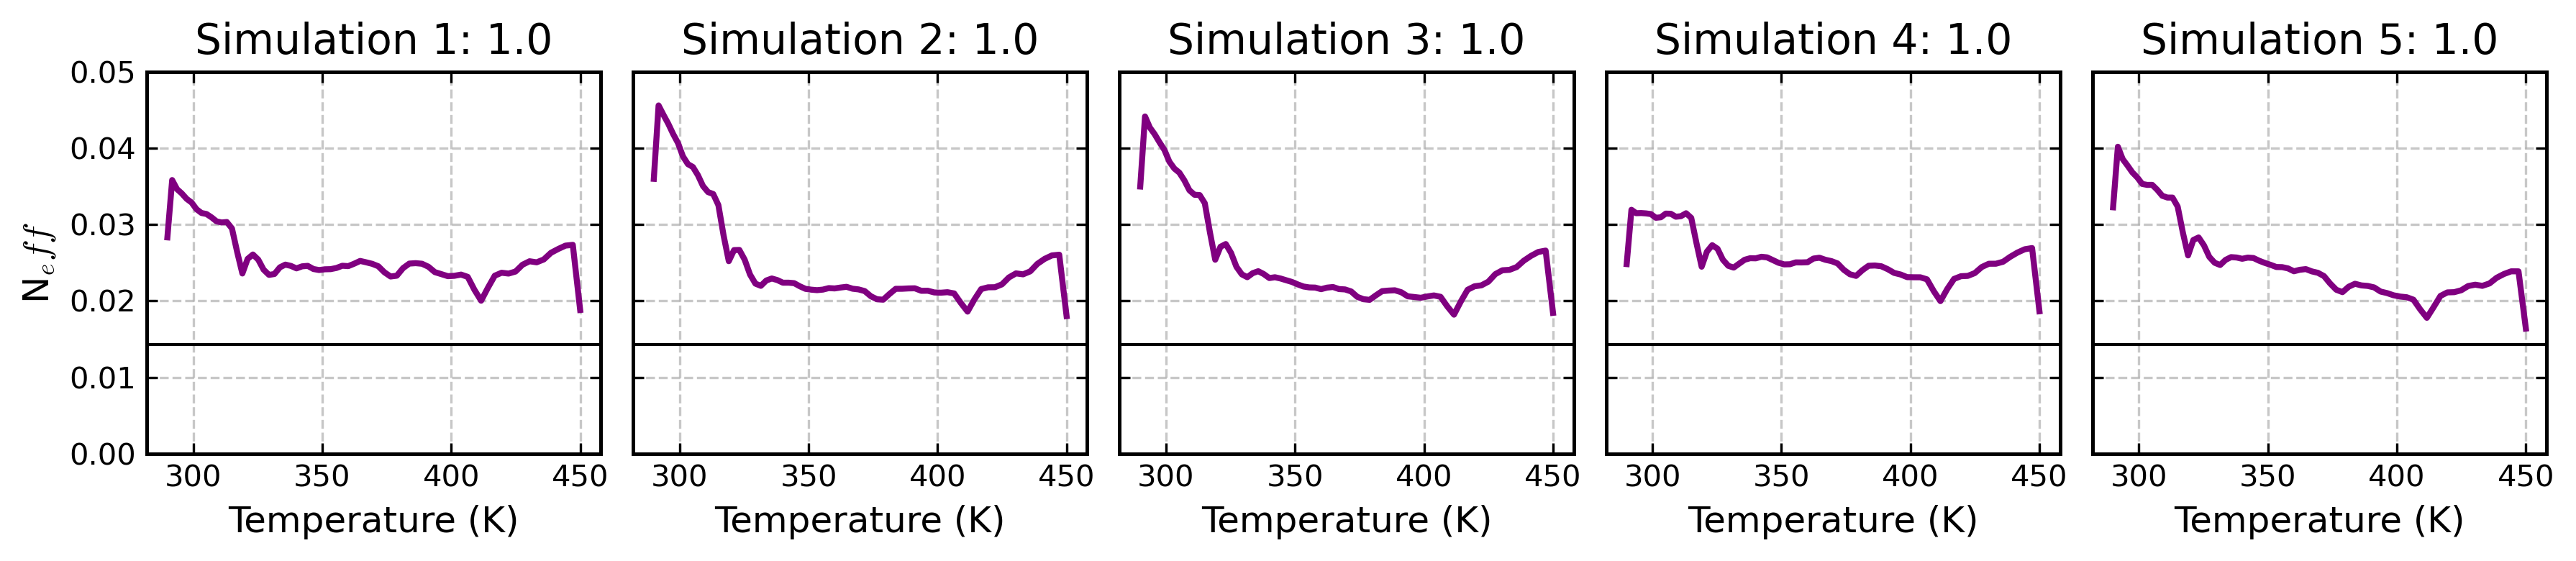

In [2]:
# effective sample size across temperatures for each simulation

nsims = 5

kb=0.008314
T0 = 300
kbt = kb*T0

temps = np.geomspace(290,450,70)


fig, axes = plt.subplots(
    nrows=1, ncols=nsims, figsize=(12, 2.7), sharex="col", sharey="row"
)

for sim in range(nsims):
    # Load data
    data = read_colvar(path+f'COLVAR.{sim}')

    # Time arrays in μs
    time_data = data[:, 0] / 1e6        # ps -> μs
    # Apply cutoff at 5 µs
    mask_data = time_data <= 5.0 
    time_data = time_data[mask_data]
    data = data[mask_data] 
    bias = data[:,2]
    ene = data[:,1] # U

    neffs = []
    for T in temps:
        # log weights
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        # sampling efficiency
        shift = np.log(len(logw))
        neff = np.exp(2 * logsumexp(logw) - logsumexp(2 * logw) - shift)
        neffs.append(neff)

    axes[sim].plot(temps, neffs, color='purple')
    
    # Calculate a quality score (fraction of temps above 1/n_temp_steps)
    neffs = np.array(neffs)
    score = np.sum(neffs>(1/temps.shape[0]))*1 / len(temps)
    score = np.round(score, 2)
    
    if sim == 0:
        axes[sim].set_ylabel("N$_eff$")
    
    
    axes[sim].set_xlabel("Temperature (K)")

    # Add column titles
    axes[sim].set_title(f"Simulation {sim+1}: {score}")

    axes[sim].set_ylim(0,0.05)
    axes[sim].axhline(1/temps.shape[0], color = 'black',linestyle='solid', linewidth=1.)

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_Neffs.pdf")



In [6]:
# check and calculate the fraction of cis peptide bonds for all simulations/peptide bonds
# save fractions to a csv file
# print a warning if any amides have a fraction above 0%
kb=0.008314
T0 = 300
T = 300
kbt = kb*T0
nsims = 5



for sim in range(nsims):
    # Load data
    data = read_colvar(path+f'COLVAR.{sim}')[::5]
    OMEGAS = np.loadtxt(path+f'OMEGAS.{sim}') 

    # Time arrays in μs
    time_data = data[:, 0] / 1e6        # ps -> μs
    # Apply cutoff at 5 µs
    mask_data = time_data <= 5.0 
    time_data = time_data[mask_data]
    data = data[mask_data]
    OMEGAS = OMEGAS[mask_data]   
    n_residues = OMEGAS.shape[1]-1
    residues = np.arange(2,n_residues+2)

    # Calculate weights
    bias = data[:,2]
    ene = data[:,1] 
    logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
    w = softmax(logw)
    w = w/np.sum(w)

    pop_cis = []
    for i in range(n_residues):
        omegas = np.abs(OMEGAS[:,1+i])
        cis_frames = np.where(omegas < np.deg2rad(50.0))[0]
        if cis_frames.shape[0]==0:
            pop_cis.append(float(0))
        else:
            pop_cis.append(np.sum(w[cis_frames]))

    pop_cis = np.array(pop_cis)
    pop_cis = np.round(pop_cis*100, 1)

    df = pd.DataFrame()
    df['Residue'] = residues
    df['% cis'] = pop_cis
    print(df)
    df.to_csv(output_path+f'{prod_name}_omegas_fraction_cis_{sim}.csv',index=False)



    Residue  % cis
0         2    0.0
1         3    0.0
2         4    0.0
3         5    0.0
4         6    0.0
5         7    0.0
6         8    0.0
7         9    0.0
8        10    0.0
9        11    0.0
10       12    0.0
11       13    0.0
12       14    0.0
13       15    0.0
14       16    0.0
15       17    0.0
16       18    0.0
17       19    0.0
18       20    0.0
19       21    0.0
20       22    0.0
21       23    0.0
22       24    0.0
23       25    0.0
24       26    0.0
25       27    0.0
26       28    0.0
27       29    0.0
28       30    0.0
29       31    0.0
30       32    0.0
31       33    0.0
32       34    0.0
33       35    0.0
34       36    0.0
35       37    0.0
36       38    0.0
37       39    0.0
38       40    0.0
39       41    0.0
40       42    0.0
    Residue  % cis
0         2    0.0
1         3    0.0
2         4    0.0
3         5    0.0
4         6    0.0
5         7    0.0
6         8    0.0
7         9    0.0
8        10    0.0
9        11 

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


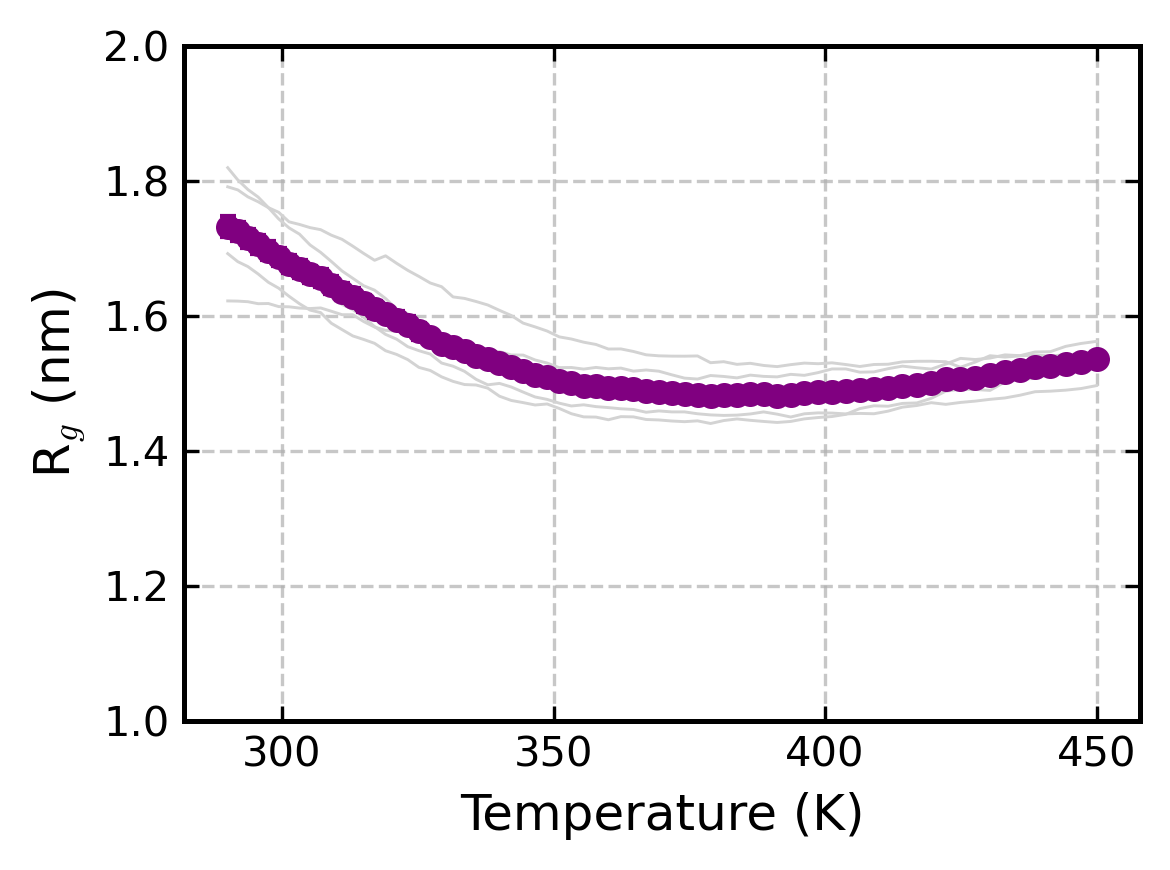

In [2]:
# Rg as a function of temp (avg + std_err) - error obtained by blocking analysis on concatenated dataset

kb=0.008314
T0 = 300
kbt = kb*T0
nsims = 5

temps = np.geomspace(290,450,70)

plt.figure(figsize = (4,3))

# load data and concatenate
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpCVS = tmpCVS[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        CVS = np.concatenate((CVS, tmpCVS), axis=0)



# calculate the profiles from each simulation individually
for sim in range(nsims):
    rg_individual = []
    tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
    tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
    # Time arrays in μs
    time_data = tmpdata[:, 0] / 1e6        # ps -> μs
    # Apply cutoff at 5 µs
    mask_data = time_data <= 5.0 
    time_data = time_data[mask_data]
    tmpdata = tmpdata[mask_data]
    tmpCVS = tmpCVS[mask_data]  
    bias = tmpdata[:,2]
    ene = tmpdata[:,1] # U
    for T in temps:
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)
        rg_individual.append(np.average(tmpCVS[:,1], weights=w))

    plt.plot(temps, rg_individual, color = 'lightgrey', linewidth=0.7)

# analysis of concatenated data
rg = []
rg_err = []

for T in temps:

    # now average and error analysis of concatenated data
    bias = data[:,2]
    ene = data[:,1] # U
    logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
    w = softmax(logw)
    w = w/np.sum(w)
    # remove frames with w=0
    mask = w != 0
    data_clean = CVS[:,1][mask]
    weights_clean = w[mask]

    # run blocking analysis
    reblock_data = pyblock.blocking.reblock(data_clean, weights=weights_clean)
    opt = pyblock.blocking.find_optimal_block(len(data_clean), reblock_data)[0]
    mu = np.average(data_clean, weights=weights_clean)
    std_err = reblock_data[opt][4]
    rg.append(mu)
    rg_err.append(std_err)
    
# save data
df = pd.DataFrame()
df['T (K)'] = temps
df['Rg (nm)'] = rg
df['±'] = rg_err
df.to_csv(output_path+f"{prod_name}_Rg_vs_Temp.csv",index=False)
plt.errorbar(temps, rg, rg_err, fmt='o-', color = 'purple', capsize = 2, markersize = 5, linewidth=0.7, elinewidth=0.7)
plt.xlabel('Temperature (K)')
plt.ylabel('R$_g$ (nm)')
plt.ylim(1,2)
plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_Rg_vs_Temp.pdf")
        
    

In [4]:
# average Rg at 300K

kb=0.008314
T0 = 300
T=300
kbt = kb*T0
nsims = 5


# load data and concatenate
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpCVS = tmpCVS[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        CVS = np.concatenate((CVS, tmpCVS), axis=0)


# analysis of concatenated data
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
data_clean = CVS[:,1][mask]
weights_clean = w[mask]

# run blocking analysis
reblock_data = pyblock.blocking.reblock(data_clean, weights=weights_clean)
opt = pyblock.blocking.find_optimal_block(len(data_clean), reblock_data)[0]
mu = np.average(data_clean, weights=weights_clean)
std_err = reblock_data[opt][4]
print(opt)
print(data.shape)

# save data
df = pd.DataFrame()
df['Rg (nm)'] = [np.round(mu, 4)]
df['±'] = [np.round(std_err, 4)]
df.to_csv(output_path+f"{prod_name}_Rg_at_{T}K.csv",index=False)
df
        
    

12
(2500005, 3)


Rg (nm)       ±
0   1.6833  0.0138

In [5]:
# average alphaRMSD at 300K

kb=0.008314
T0 = 300
T=300
kbt = kb*T0
nsims = 5


# load data and concatenate
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpCVS = tmpCVS[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        CVS = np.concatenate((CVS, tmpCVS), axis=0)


# analysis of concatenated data
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
data_clean = CVS[:,2][mask]
weights_clean = w[mask]

# run blocking analysis
reblock_data = pyblock.blocking.reblock(data_clean, weights=weights_clean)
opt = pyblock.blocking.find_optimal_block(len(data_clean), reblock_data)[0]
mu = np.average(data_clean, weights=weights_clean)
std_err = reblock_data[opt][4]
print(opt)
print(data.shape)

# save data
df = pd.DataFrame()
df['alphaRMSD'] = [np.round(mu, 4)]
df['±'] = [np.round(std_err, 4)]
df.to_csv(output_path+f"{prod_name}_alphaRMSD_at_{T}K.csv",index=False)
df
        
    

13
(2500005, 3)


alphaRMSD       ±
0     2.9415  0.1969

In [16]:
reblock_data

[BlockTuple(block=0, ndata=1112774, mean=array(1.68328827), cov=0.11439899080187063, std_err=array(0.00113326), std_err_err=array(2.68493116e-06)),
 BlockTuple(block=1, ndata=556387, mean=array(1.68328827), cov=0.1143687491655258, std_err=array(0.00127585), std_err_err=array(3.40357723e-06)),
 BlockTuple(block=2, ndata=278193, mean=array(1.68328827), cov=0.11431324002346376, std_err=array(0.00146909), std_err_err=array(4.51374109e-06)),
 BlockTuple(block=3, ndata=139096, mean=array(1.68328827), cov=0.11421026496911009, std_err=array(0.0017257), std_err_err=array(6.23114736e-06)),
 BlockTuple(block=4, ndata=69548, mean=array(1.68328827), cov=0.11399671544493269, std_err=array(0.00207275), std_err_err=array(8.99789896e-06)),
 BlockTuple(block=5, ndata=34774, mean=array(1.68328827), cov=0.11354789945738436, std_err=array(0.002557), std_err_err=array(1.37204332e-05)),
 BlockTuple(block=6, ndata=17387, mean=array(1.68328827), cov=0.11246302967999525, std_err=array(0.00323071), std_err_err=a

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


sum probs: 0.9999999999999996


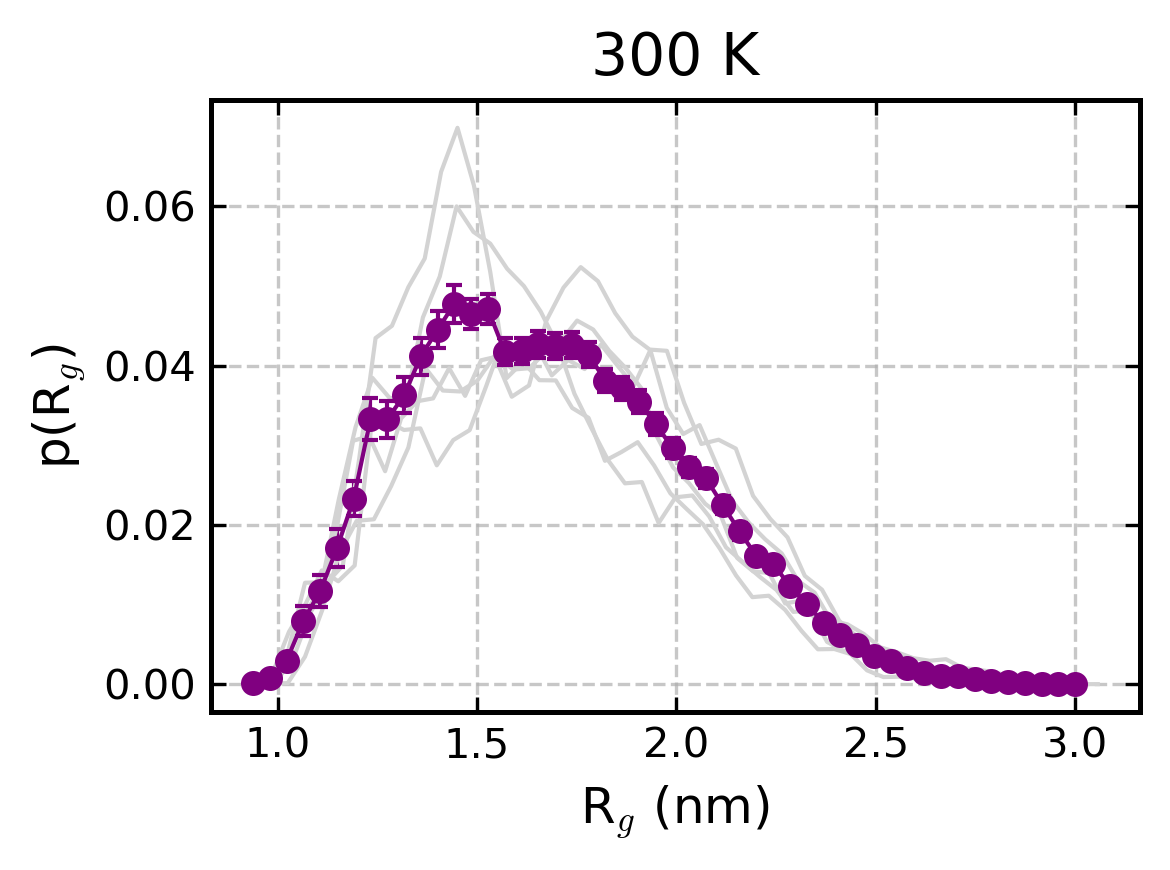

In [3]:
# Rg distribution at 300 K (avg ± std_err)

kb=0.008314
T0 = 300
kbt = kb*T0
T = 300
nsims = 5
nbins = 50

# initialise figure
plt.figure(figsize = (4,3))

# load data and concatenate (and plot distributions of individual trajectories)
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]

        # plot
        # weights
        bias = data[:,2]
        ene = data[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)
        rgdata = CVS[:,1]
        counts, bin_edges = np.histogram(rgdata, bins=nbins, density=False, weights=w)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        p = counts / np.sum(counts)
        plt.plot(bin_centers, p, color = 'lightgrey', linewidth=1.)
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpCVS = tmpCVS[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        CVS = np.concatenate((CVS, tmpCVS), axis=0)

        # plot
        # weights
        bias = tmpdata[:,2]
        ene = tmpdata[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)
        rgdata = tmpCVS[:,1]
        counts, bin_edges = np.histogram(rgdata, bins=nbins, density=False, weights=w)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        p = counts / np.sum(counts)
        plt.plot(bin_centers, p, color = 'lightgrey', linewidth=1.)

# rg of concatenated trajs
rgdata = CVS[:,1]

# weights
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
rgdata = rgdata[mask]
weights_clean = w[mask]


# histogram
counts, bin_edges = np.histogram(rgdata, bins=nbins, density=False, weights=weights_clean)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
N = len(rgdata)

probs = np.zeros(nbins)
errs = np.zeros(nbins)

# for each bin build indicator time series and use pyblock
for i in range(nbins):
    left, right = bin_edges[i], bin_edges[i+1]
    # include left edge, exclude right edge except for last bin:
    if i == nbins-1:
        indicator = ((rgdata >= left) & (rgdata <= right)).astype(float)
    else:
        indicator = ((rgdata >= left) & (rgdata < right)).astype(float)

    # if the indicator is constant (no hits or all hits) handle trivially
    if indicator.sum() == 0:
        probs[i] = 0.0
        errs[i] = 0.0
        continue
    if indicator.sum() == N:
        probs[i] = 1.0
        errs[i] = 0.0
        continue

    # run pyblock: reblock returns list-like, find_optimal_block returns index (float -> convert)
    reblocked = pyblock.blocking.reblock(indicator, weights=weights_clean)  # default no weights
    opt = int(pyblock.blocking.find_optimal_block(len(indicator), reblocked)[0])
    mean_bin = np.average(indicator, weights=weights_clean)
    stderr_bin = reblocked[opt].std_err

    probs[i] = mean_bin
    errs[i] = stderr_bin

# sanity: probabilities should sum approx to 1 (if using counts-->probs per-bin)
print("sum probs:", probs.sum())

# save data
df= pd.DataFrame()
df['Rg (nm)'] = bin_centers
df['p(Rg)'] = probs
df['±'] = errs
df.to_csv(output_path+f"{prod_name}_prob_Rg_{T}K.csv", index=False)

# plot PMF with blocking error bars
plt.title(f"{T} K")
plt.errorbar(bin_centers, probs, yerr=errs, fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='purple')
plt.xlabel("R$_g$ (nm)")
plt.ylabel("p(R$_g$)")
plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_prob_Rg_{T}K.pdf")

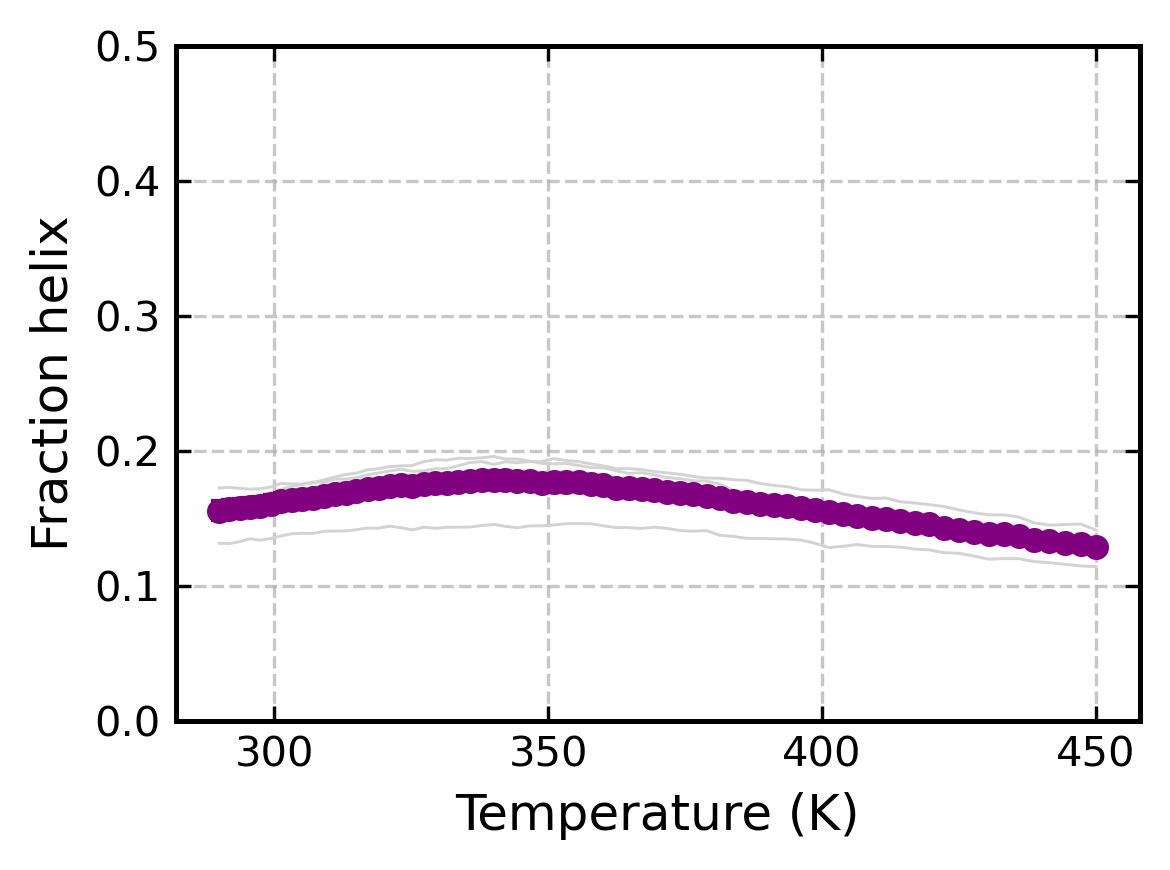

In [4]:
# Helical fraction as a function of temperature from DSSP (H, G, I)

kb=0.008314
T0 = 300
kbt = kb*T0
nsims = 5

temps = np.geomspace(290,450,70)

plt.figure(figsize = (4,3))

# load data and concatenate
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpdssp = np.array(tmpdssp)[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

# calculate the profiles from each simulation individually
for sim in range(nsims):
    individual = []
    tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
    with open(path+f'dssp{sim}.dat') as f:
        tmpdssp = [line.strip() for line in f]
    # Time arrays in μs
    time_data = tmpdata[:, 0] / 1e6        # ps -> μs
    # Apply cutoff at 5 µs
    mask_data = time_data <= 5.0 
    time_data = time_data[mask_data]
    tmpdata = tmpdata[mask_data]
    tmpdssp = np.array(tmpdssp)[mask_data]  
    bias = tmpdata[:,2]
    ene = tmpdata[:,1] # U
    # Compute helical fraction for each frame
    helical_frac = np.array([helical_fraction(frame) for frame in tmpdssp])
    for T in temps:
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)
        individual.append(np.average(helical_frac, weights=w))

    plt.plot(temps, individual, color = 'lightgrey', linewidth=0.7)

# analysis of concatenated data
helix = []
helix_err = []

# Compute helical fraction for each frame
helical_frac = np.array([helical_fraction(frame) for frame in dssp])

for T in temps:

    # now average and error analysis of concatenated data
    bias = data[:,2]
    ene = data[:,1] # U
    logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
    w = softmax(logw)
    w = w/np.sum(w)
    # remove frames with w=0
    mask = w != 0
    data_clean = helical_frac[mask]
    weights_clean = w[mask]

    # run blocking analysis
    reblock_data = pyblock.blocking.reblock(data_clean, weights=weights_clean)
    opt = pyblock.blocking.find_optimal_block(len(data_clean), reblock_data)[0]
    mu = np.average(data_clean, weights=weights_clean)
    std_err = reblock_data[opt][4]
    helix.append(mu)
    helix_err.append(std_err)
    
# save data
df = pd.DataFrame()
df['T (K)'] = temps
df['Helix (%)'] = helix
df['±'] = helix_err
df.to_csv(output_path+f"{prod_name}_HelicalFrac_vs_Temp.csv",index=False)
plt.errorbar(temps, helix, helix_err, fmt='o-', color = 'purple', capsize = 2, markersize = 5, linewidth=0.7, elinewidth=0.7)
plt.xlabel('Temperature (K)')
plt.ylabel('Fraction helix')
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_HelicalFrac_vs_Temp.pdf")
        
    

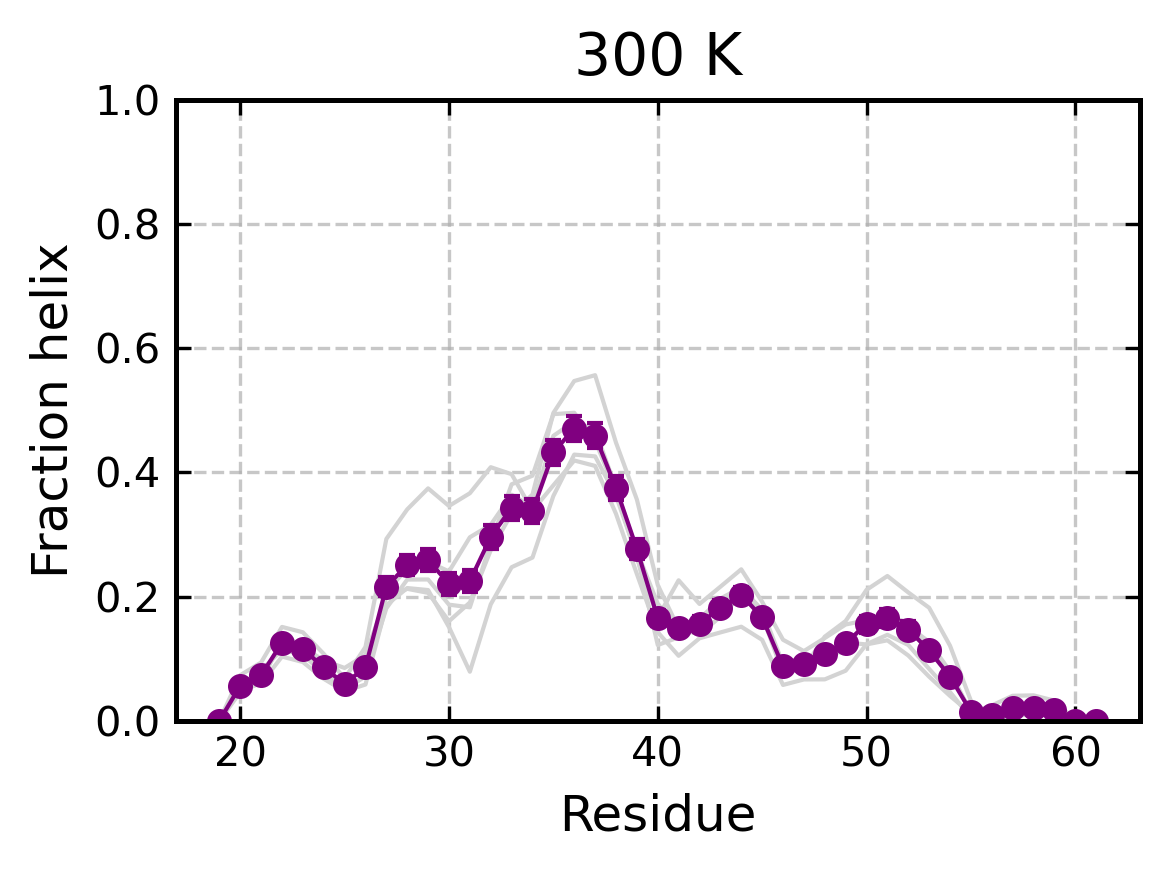

In [5]:
# Helicity at 300 K

kb=0.008314
T0 = 300
kbt = kb*T0
nsims = 5
T = 300
residues = np.arange(19, 61+1)

# initialise the figure

plt.figure(figsize = (4,3))

# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
        bias = data[:,2]
        ene = data[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)

        plt.plot(residues, np.average(dssp_to_helicity(dssp), weights=w, axis=0), linewidth=1., color ='lightgrey')

    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpdssp = np.array(tmpdssp)[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

        bias = tmpdata[:,2]
        ene = tmpdata[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)

        plt.plot(residues, np.average(dssp_to_helicity(tmpdssp), weights=w, axis=0), linewidth=1., color ='lightgrey')

# helicity for all, concatenated frames
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
weights_clean = w[mask]
H = dssp_to_helicity(dssp[mask])

# H: shape (n_frames, n_residues)
n_frames, n_residues = H.shape

means = np.zeros(n_residues)
stderr = np.zeros(n_residues)

for j in range(n_residues):
    series = H[:, j]  # helicity time series for residue j
    if np.mean(series)==0:
        means[j] = float(0)
        stderr[j] = float(0)
        continue
    reblock_data = pyblock.blocking.reblock(series, weights=weights_clean)
    optimal = int(pyblock.blocking.find_optimal_block(len(series), reblock_data)[0])
    means[j] = np.average(series, weights=weights_clean)
    stderr[j] = reblock_data[optimal].std_err

# save data
df= pd.DataFrame()
df['Residue'] = residues
df['Fraction helix'] = means
df['±'] = stderr
df.to_csv(output_path+f"{prod_name}_perres_helicity_{T}K.csv", index=False)

# plot PMF with blocking error bars
plt.title(f"{T} K")
plt.errorbar(residues, means, yerr=stderr, fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='purple')
plt.xlabel("Residue")
plt.ylabel("Fraction helix")
plt.ylim(0,1.)
plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_perres_helicity_{T}K.pdf")

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


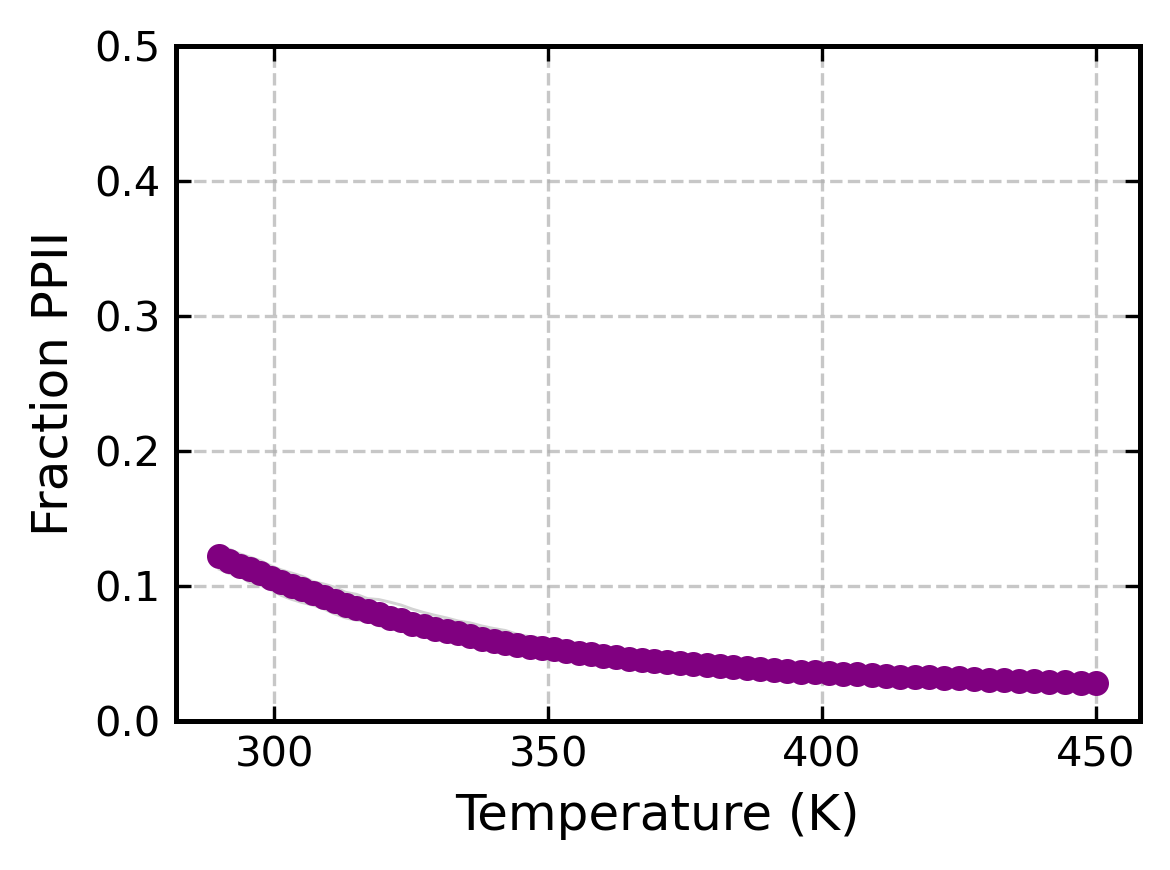

In [3]:
# Helical fraction as a function of temperature from DSSP (H, G, I)

kb=0.008314
T0 = 300
kbt = kb*T0
nsims = 5

temps = np.geomspace(290,450,70)

plt.figure(figsize = (4,3))

# load data and concatenate
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpdssp = np.array(tmpdssp)[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

# calculate the profiles from each simulation individually
for sim in range(nsims):
    individual = []
    tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
    with open(path+f'dssp{sim}.dat') as f:
        tmpdssp = [line.strip() for line in f]
    # Time arrays in μs
    time_data = tmpdata[:, 0] / 1e6        # ps -> μs
    # Apply cutoff at 5 µs
    mask_data = time_data <= 5.0 
    time_data = time_data[mask_data]
    tmpdata = tmpdata[mask_data]
    tmpdssp = np.array(tmpdssp)[mask_data]  
    bias = tmpdata[:,2]
    ene = tmpdata[:,1] # U
    # Compute helical fraction for each frame
    helical_frac = np.array([PPII_fraction(frame) for frame in tmpdssp])
    for T in temps:
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)
        individual.append(np.average(helical_frac, weights=w))

    plt.plot(temps, individual, color = 'lightgrey', linewidth=0.7)

# analysis of concatenated data
helix = []
helix_err = []

# Compute helical fraction for each frame
helical_frac = np.array([PPII_fraction(frame) for frame in dssp])

for T in temps:

    # now average and error analysis of concatenated data
    bias = data[:,2]
    ene = data[:,1] # U
    logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
    w = softmax(logw)
    w = w/np.sum(w)
    # remove frames with w=0
    mask = w != 0
    data_clean = helical_frac[mask]
    weights_clean = w[mask]

    # run blocking analysis
    reblock_data = pyblock.blocking.reblock(data_clean, weights=weights_clean)
    opt = pyblock.blocking.find_optimal_block(len(data_clean), reblock_data)[0]
    mu = np.average(data_clean, weights=weights_clean)
    std_err = reblock_data[opt][4]
    helix.append(mu)
    helix_err.append(std_err)
    
# save data
df = pd.DataFrame()
df['T (K)'] = temps
df['Helix (%)'] = helix
df['±'] = helix_err
df.to_csv(output_path+f"{prod_name}_PPIIFrac_vs_Temp.csv",index=False)
plt.errorbar(temps, helix, helix_err, fmt='o-', color = 'purple', capsize = 2, markersize = 5, linewidth=0.7, elinewidth=0.7)
plt.xlabel('Temperature (K)')
plt.ylabel('Fraction PPII')
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_PPIIFrac_vs_Temp.pdf")
        
    

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


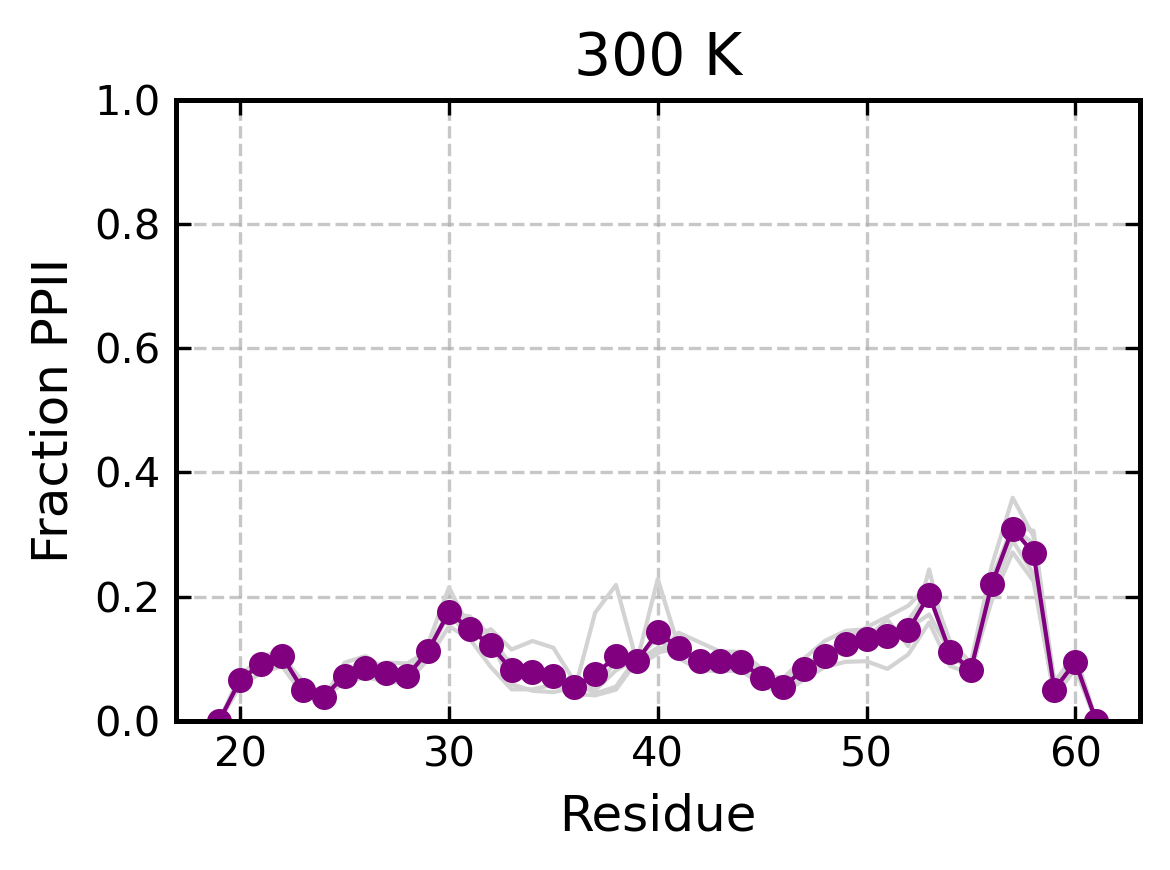

In [4]:
# PPII at 300 K

kb=0.008314
T0 = 300
kbt = kb*T0
nsims = 5
T = 300
residues = np.arange(19, 61+1)

# initialise the figure

plt.figure(figsize = (4,3))

# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
        bias = data[:,2]
        ene = data[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)

        plt.plot(residues, np.average(dssp_to_PPII(dssp), weights=w, axis=0), linewidth=1., color ='lightgrey')

    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpdssp = np.array(tmpdssp)[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

        bias = tmpdata[:,2]
        ene = tmpdata[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)

        plt.plot(residues, np.average(dssp_to_PPII(tmpdssp), weights=w, axis=0), linewidth=1., color ='lightgrey')

# helicity for all, concatenated frames
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
weights_clean = w[mask]
H = dssp_to_PPII(dssp[mask])

# H: shape (n_frames, n_residues)
n_frames, n_residues = H.shape

means = np.zeros(n_residues)
stderr = np.zeros(n_residues)

for j in range(n_residues):
    series = H[:, j]  # helicity time series for residue j
    if np.mean(series)==0:
        means[j] = float(0)
        stderr[j] = float(0)
        continue
    reblock_data = pyblock.blocking.reblock(series, weights=weights_clean)
    optimal = int(pyblock.blocking.find_optimal_block(len(series), reblock_data)[0])
    means[j] = np.average(series, weights=weights_clean)
    stderr[j] = reblock_data[optimal].std_err

# save data
df= pd.DataFrame()
df['Residue'] = residues
df['Fraction helix'] = means
df['±'] = stderr
df.to_csv(output_path+f"{prod_name}_perres_PPII_{T}K.csv", index=False)

# plot PMF with blocking error bars
plt.title(f"{T} K")
plt.errorbar(residues, means, yerr=stderr, fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='purple')
plt.xlabel("Residue")
plt.ylabel("Fraction PPII")
plt.ylim(0,1.)
plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_perres_PPII_{T}K.pdf")

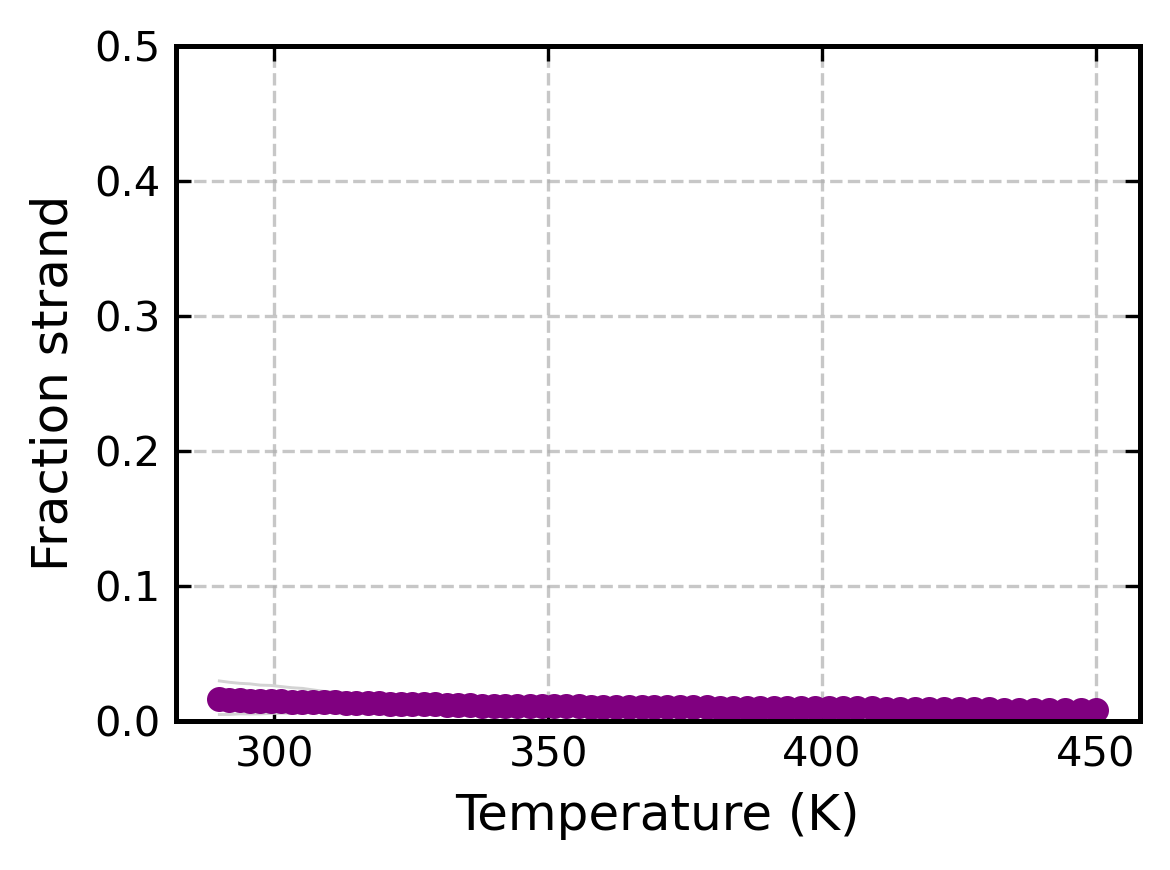

In [6]:
# beta strand fraction as a function of temperature (E, B)

kb=0.008314
T0 = 300
kbt = kb*T0
nsims = 5

temps = np.geomspace(290,450,70)

plt.figure(figsize = (4,3))

# load data and concatenate
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpdssp = np.array(tmpdssp)[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

# calculate the profiles from each simulation individually
for sim in range(nsims):
    individual = []
    tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
    with open(path+f'dssp{sim}.dat') as f:
        tmpdssp = [line.strip() for line in f]
    # Time arrays in μs
    time_data = tmpdata[:, 0] / 1e6        # ps -> μs
    # Apply cutoff at 5 µs
    mask_data = time_data <= 5.0 
    time_data = time_data[mask_data]
    tmpdata = tmpdata[mask_data]
    tmpdssp = np.array(tmpdssp)[mask_data]  
    bias = tmpdata[:,2]
    ene = tmpdata[:,1] # U
    # Compute beta fraction for each frame
    beta_frac = np.array([betastrand_fraction(frame) for frame in tmpdssp])
    for T in temps:
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)
        individual.append(np.average(beta_frac, weights=w))

    plt.plot(temps, individual, color = 'lightgrey', linewidth=0.7)

# analysis of concatenated data
beta = []
beta_err = []

# Compute helical fraction for each frame
beta_frac = np.array([betastrand_fraction(frame) for frame in dssp])

for T in temps:

    # now average and error analysis of concatenated data
    bias = data[:,2]
    ene = data[:,1] # U
    logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
    w = softmax(logw)
    w = w/np.sum(w)
    # remove frames with w=0
    mask = w != 0
    data_clean = beta_frac[mask]
    weights_clean = w[mask]

    # run blocking analysis
    reblock_data = pyblock.blocking.reblock(data_clean, weights=weights_clean)
    opt = pyblock.blocking.find_optimal_block(len(data_clean), reblock_data)[0]
    mu = np.average(data_clean, weights=weights_clean)
    std_err = reblock_data[opt][4]
    beta.append(mu)
    beta_err.append(std_err)
    
# save data
df = pd.DataFrame()
df['T (K)'] = temps
df['Beta-strand (%)'] = beta
df['±'] = beta_err
df.to_csv(output_path+f"{prod_name}_BetaFrac_vs_Temp.csv",index=False)
plt.errorbar(temps, beta, beta_err, fmt='o-', color = 'purple', capsize = 2, markersize = 5, linewidth=0.7, elinewidth=0.7)
plt.xlabel('Temperature (K)')
plt.ylabel('Fraction strand')
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_BetalFrac_vs_Temp.pdf")
        
    

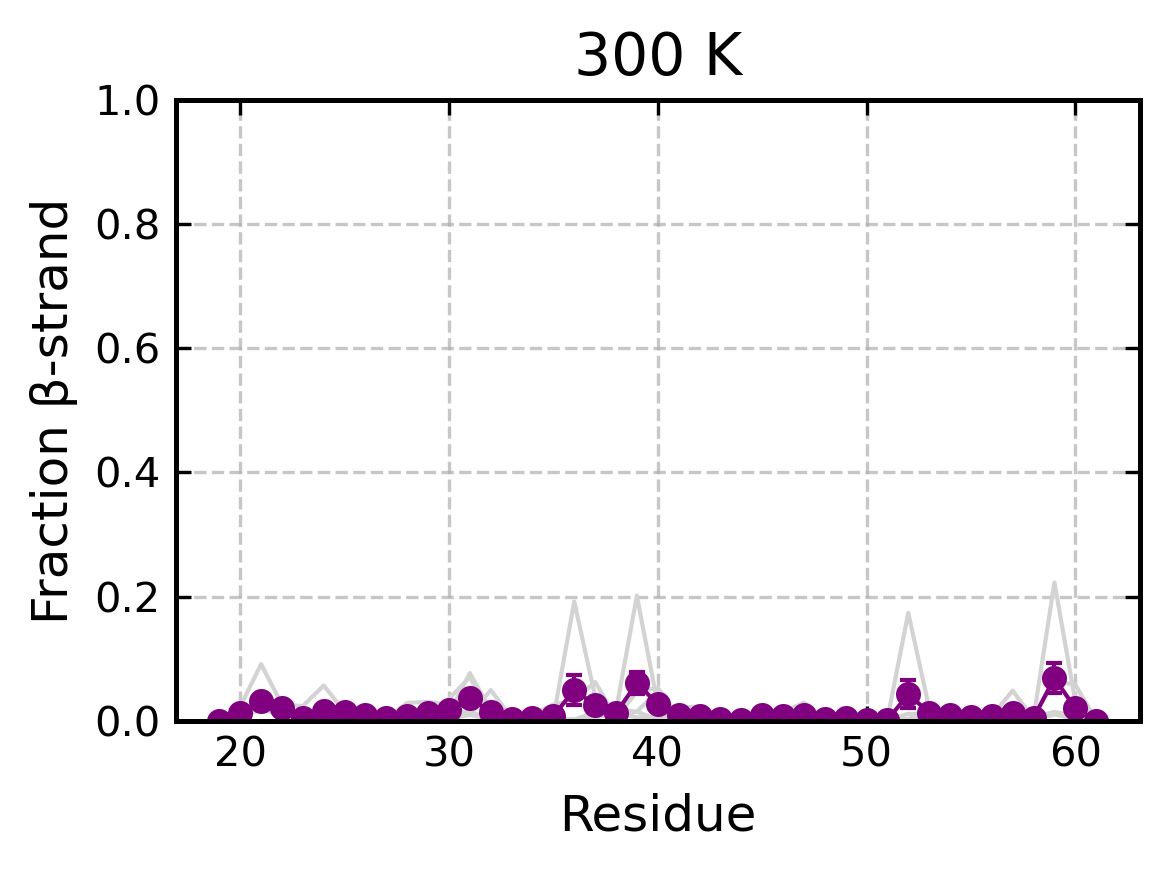

In [ ]:
# strand propensity at 300 K

kb=0.008314
T0 = 300
kbt = kb*T0
nsims = 5
T = 300
residues = np.arange(19, 61+1)

# initialise the figure

plt.figure(figsize = (4,3))

# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
        bias = data[:,2]
        ene = data[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)

        plt.plot(residues, np.average(dssp_to_strand(dssp), weights=w, axis=0), linewidth=1., color ='lightgrey')

    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpdssp = np.array(tmpdssp)[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

        bias = tmpdata[:,2]
        ene = tmpdata[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)

        plt.plot(residues, np.average(dssp_to_strand(tmpdssp), weights=w, axis=0), linewidth=1., color ='lightgrey')

# helicity for all, concatenated frames
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
weights_clean = w[mask]
S = dssp_to_strand(dssp[mask])

# S: shape (n_frames, n_residues)
n_frames, n_residues = S.shape

means = np.zeros(n_residues)
stderr = np.zeros(n_residues)

for j in range(n_residues):
    series = S[:, j]  # helicity time series for residue j
    if np.mean(series)==0:
        means[j] = float(0)
        stderr[j] = float(0)
        continue
    reblock_data = pyblock.blocking.reblock(series, weights=weights_clean)
    optimal = int(pyblock.blocking.find_optimal_block(len(series), reblock_data)[0])
    means[j] = np.average(series, weights=weights_clean)
    stderr[j] = reblock_data[optimal].std_err

# save data
df= pd.DataFrame()
df['Residue'] = residues
df['Fraction strand'] = means
df['±'] = stderr
df.to_csv(output_path+f"{prod_name}_perres_bstrand_{T}K.csv", index=False)

# plot PMF with blocking error bars
plt.title(f"{T} K")
plt.errorbar(residues, means, yerr=stderr, fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='purple')
plt.xlabel("Residue")
plt.ylabel("Fraction β-strand")
plt.ylim(0,1.)
plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_perres_bstrand_{T}K.pdf")

/tmp/ipykernel_3696132/3935039062.py:75: UserWarning: The following kwargs were not used by contour: 'rasterized'
  contour = plt.contourf(


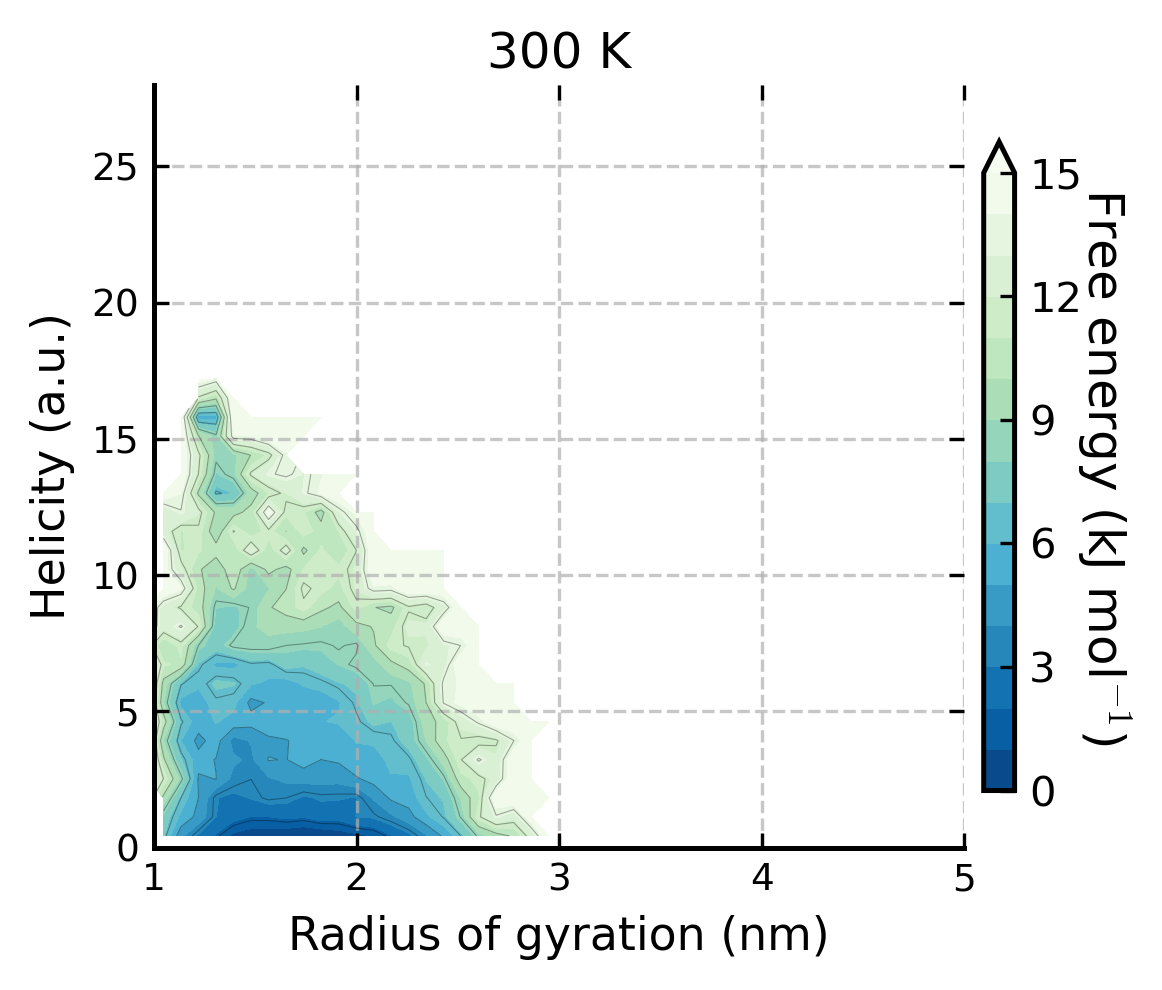

In [3]:
# 2D Map: Rg vs alphaRMSD at 300 K
max_FEL = 15
kb=0.008314
T0 = 300
T = 300
kbt = kb*T0
nsims = 3

# load data and concatenate
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpCVS = tmpCVS[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        CVS = np.concatenate((CVS, tmpCVS), axis=0)

# now average and error analysis of concatenated data
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# extract CVs
rg = CVS[:,1]
alphaRMSD = CVS[:,2]

# --- Compute 2D histogram ---
nbins = 25
H, xedges, yedges = np.histogram2d(rg, alphaRMSD, bins=nbins, weights=w, density=True)

# Avoid zeros for log
H[H <= 1e-15] = np.nan

# Convert probability to free energy (kJ/mol)
F = -kbt * np.log(H)
F = F - np.nanmin(F)  # shift minimum to 0

# Cap free energy to max FEL value
F[F > max_FEL] = max_FEL

# --- Grid centers for plotting ---
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])

# --- Pastel color map ---
cmap = plt.cm.viridis  # you can also try 'cividis', 'Spectral_r', or 'plasma'
from matplotlib.colors import LinearSegmentedColormap
pastel_cmap = LinearSegmentedColormap.from_list(
    "pastel_viridis", [plt.cm.viridis(0.1), plt.cm.viridis(0.6), plt.cm.viridis(0.9)], N=256
)

# plot

plt.figure(figsize=(4.0, 3.4), dpi=300)

# Smoother and fewer contour levels
levels = np.linspace(0, max_FEL, 16)

# Main contour plot
contour = plt.contourf(
    xcenters, ycenters, F.T,
    levels=levels,
    cmap='GnBu_r',
    extend='max',
    rasterized=True
)

for c in contour.collections:
    c.set_rasterized(True)

# --- Clean, sparse colorbar ---
cbar = plt.colorbar(contour, pad=0.02, shrink=0.85)
cbar.set_label(r"Free energy (kJ mol$^{-1}$)", rotation=270, labelpad=12)

# Fewer ticks (natural nice breakpoints)
cbar_ticks = np.linspace(0, max_FEL, 6)
cbar.set_ticks(cbar_ticks)

# --- Add subtle contour lines ---
plt.contour(
    xcenters, ycenters, F.T,
    levels=np.linspace(0, max_FEL, 10),
    colors='k',
    linewidths=0.25,
    alpha=0.35
)


# --- Refined axes ---
plt.xlabel(r"Radius of gyration (nm)", fontsize=11)
plt.ylabel("Helicity (a.u.)", fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Light padding
plt.xlim(1, 5)
plt.ylim(0, 28)

# Remove top & right spines (cleaner look)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.title(f"{T} K", fontsize=12, pad=4)

plt.tight_layout()

plt.savefig(output_path + f"{prod_name}_2D_Rg_vs_alphaRMSD.pdf",
            dpi=300, bbox_inches='tight')

/tmp/ipykernel_3696132/2597270246.py:75: UserWarning: The following kwargs were not used by contour: 'rasterized'
  contour = plt.contourf(


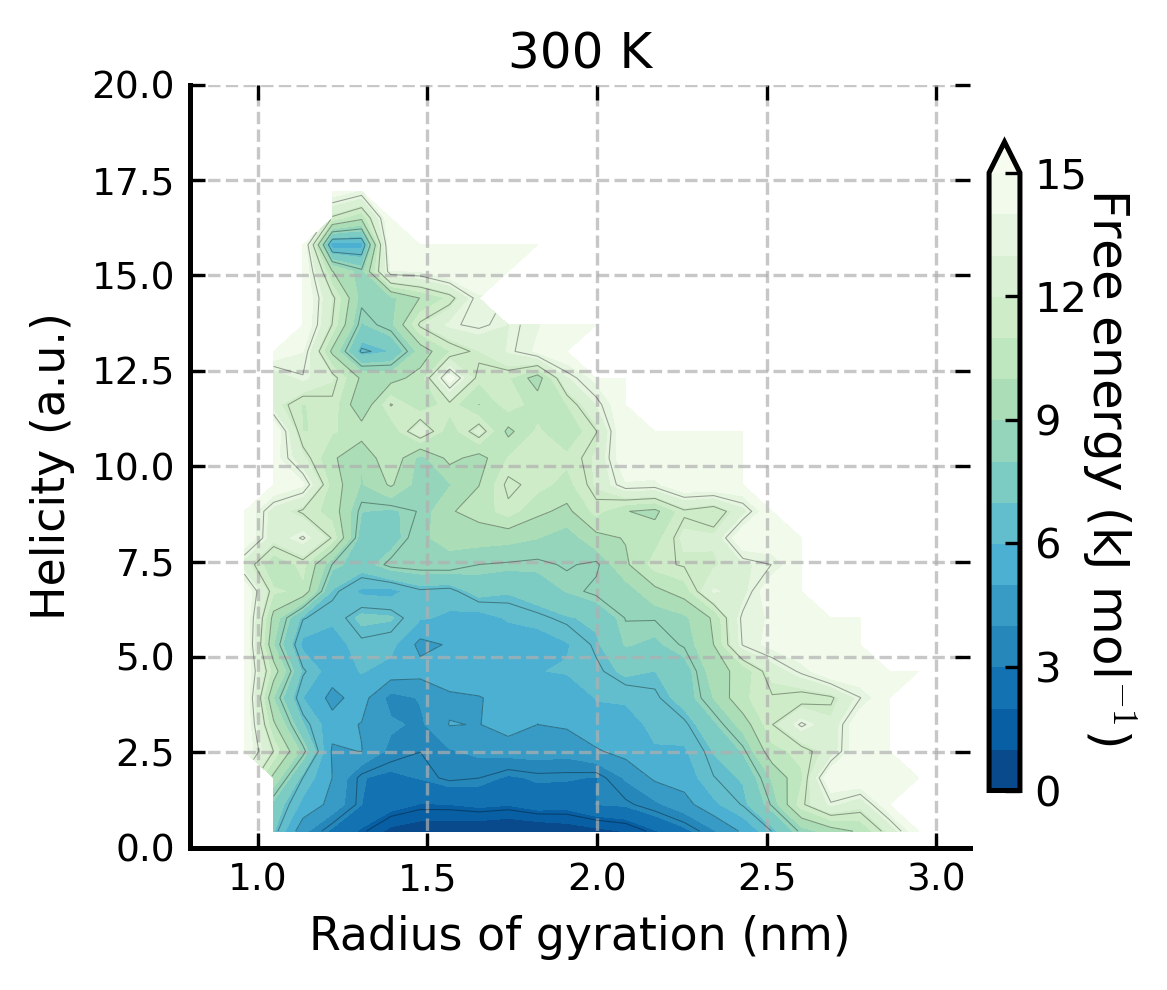

In [4]:
# 2D Map: Rg vs alphaRMSD at 300 K
max_FEL = 15
kb=0.008314
T0 = 300
T = 300
kbt = kb*T0
nsims = 3

# load data and concatenate
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpCVS = tmpCVS[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        CVS = np.concatenate((CVS, tmpCVS), axis=0)

# now average and error analysis of concatenated data
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# extract CVs
rg = CVS[:,1]
alphaRMSD = CVS[:,2]

# --- Compute 2D histogram ---
nbins = 25
H, xedges, yedges = np.histogram2d(rg, alphaRMSD, bins=nbins, weights=w, density=True)

# Avoid zeros for log
H[H <= 1e-15] = np.nan

# Convert probability to free energy (kJ/mol)
F = -kbt * np.log(H)
F = F - np.nanmin(F)  # shift minimum to 0

# Cap free energy to max FEL value
F[F > max_FEL] = max_FEL

# --- Grid centers for plotting ---
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])

# --- Pastel color map ---
cmap = plt.cm.viridis  # you can also try 'cividis', 'Spectral_r', or 'plasma'
from matplotlib.colors import LinearSegmentedColormap
pastel_cmap = LinearSegmentedColormap.from_list(
    "pastel_viridis", [plt.cm.viridis(0.1), plt.cm.viridis(0.6), plt.cm.viridis(0.9)], N=256
)

# plot

plt.figure(figsize=(4.0, 3.4), dpi=300)

# Smoother and fewer contour levels
levels = np.linspace(0, max_FEL, 16)

# Main contour plot
contour = plt.contourf(
    xcenters, ycenters, F.T,
    levels=levels,
    cmap='GnBu_r',
    extend='max',
    rasterized=True
)

for c in contour.collections:
    c.set_rasterized(True)

# --- Clean, sparse colorbar ---
cbar = plt.colorbar(contour, pad=0.02, shrink=0.85)
cbar.set_label(r"Free energy (kJ mol$^{-1}$)", rotation=270, labelpad=12)

# Fewer ticks (natural nice breakpoints)
cbar_ticks = np.linspace(0, max_FEL, 6)
cbar.set_ticks(cbar_ticks)

# --- Add subtle contour lines ---
plt.contour(
    xcenters, ycenters, F.T,
    levels=np.linspace(0, max_FEL, 10),
    colors='k',
    linewidths=0.25,
    alpha=0.35
)


# --- Refined axes ---
plt.xlabel(r"Radius of gyration (nm)", fontsize=11)
plt.ylabel("Helicity (a.u.)", fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Light padding
plt.xlim(0.8, 3.1)
plt.ylim(0, 20)

# Remove top & right spines (cleaner look)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.title(f"{T} K", fontsize=12, pad=4)

plt.tight_layout()

plt.savefig(output_path + f"{prod_name}_2D_Rg_vs_alphaRMSD_2.pdf",
            dpi=300, bbox_inches='tight')

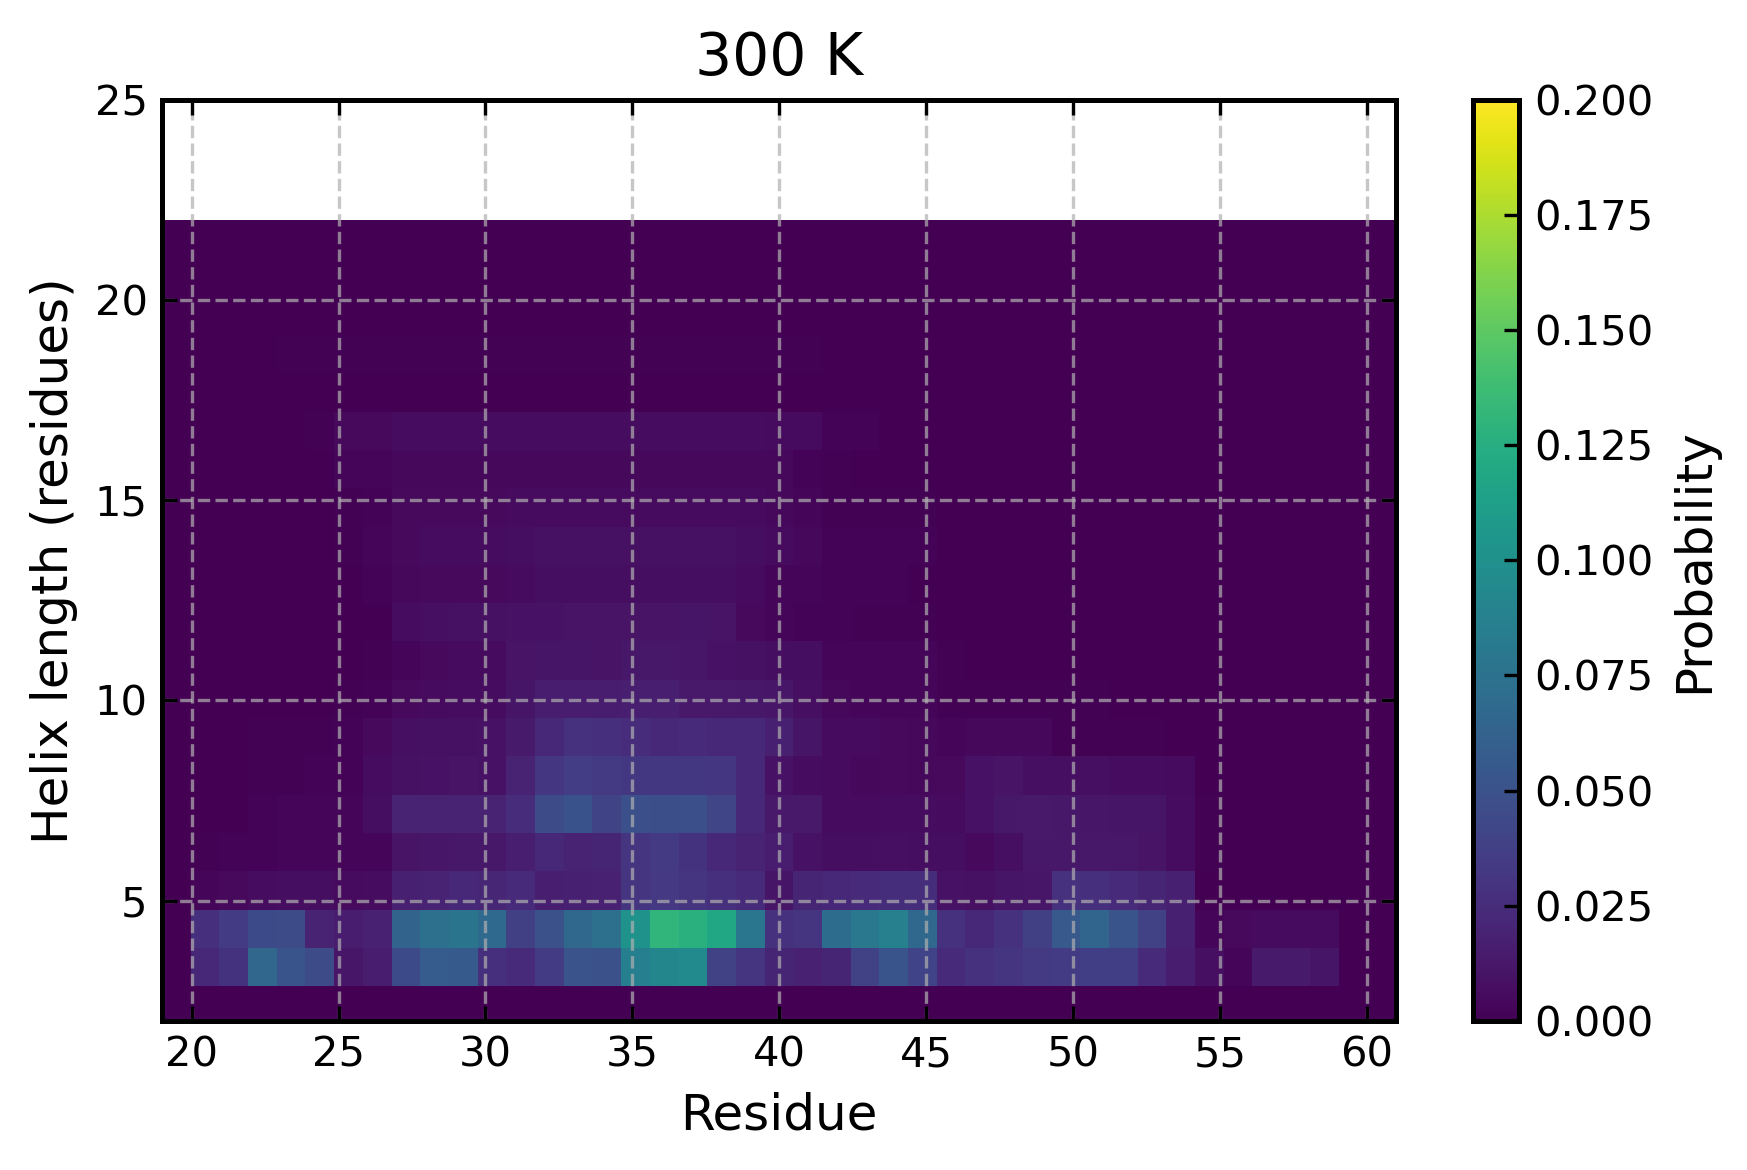

In [7]:
# 2D map: helix length vs residues 300 K 

kb=0.008314
T0 = 300
kbt = kb*T0
nsims = 5
T = 300
residues = np.arange(19, 61+1)

# Convert DSSP codes to helix map: H=1, G=1, I=1, else 0
def dssp_to_helix_binary(dssp_lines):
    helix_codes = {'H', 'G', 'I'}
    arr = np.zeros((len(dssp_lines), len(residues)), dtype=int)
    for i, line in enumerate(dssp_lines):
        arr[i, :] = [1 if c in helix_codes else 0 for c in line]
    return arr


# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
        bias = data[:,2]
        ene = data[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)

    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpdssp = np.array(tmpdssp)[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

        bias = tmpdata[:,2]
        ene = tmpdata[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = softmax(logw)
        w = w/np.sum(w)


# helicity for all, concatenated frames
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
weights_clean = w[mask]
dssp = dssp[mask]


H = dssp_to_helix_binary(dssp)
n_frames, n_residues = H.shape

# Compute helix segment lengths per residue per frame
helix_lengths = np.zeros_like(H, dtype=int)
for i in range(n_frames):
    j = 0
    while j < n_residues:
        if H[i, j] == 1:
            # start of helix segment
            start = j
            while j < n_residues and H[i, j] == 1:
                j += 1
            seglen = j - start
            helix_lengths[i, start:j] = seglen
        else:
            j += 1

# Determine maximum helix length
max_len = np.max(helix_lengths)

# 2D probability map: length (y) vs residue (x)
prob_map = np.zeros((max_len + 1, n_residues))  # include length=0 for non-helical

for j in range(n_residues):
    for i in range(n_frames):
        L = helix_lengths[i, j]
        prob_map[L, j] += weights_clean[i]

# Normalize columns to get probabilities
prob_map /= prob_map.sum(axis=0, keepdims=True)

# Plot
plt.figure(figsize=(6, 4))
plt.imshow(prob_map, origin='lower', aspect='auto', cmap='viridis',
           extent=[residues[0], residues[-1], 0, max_len])
plt.clim(0,0.2)
plt.ylim(2,25)
plt.colorbar(label='Probability')
plt.xlabel('Residue')
plt.ylabel('Helix length (residues)')
plt.title(f'{T} K')
plt.tight_layout()
plt.savefig(output_path + f"{prod_name}_helix_length_map_{T}K.pdf")



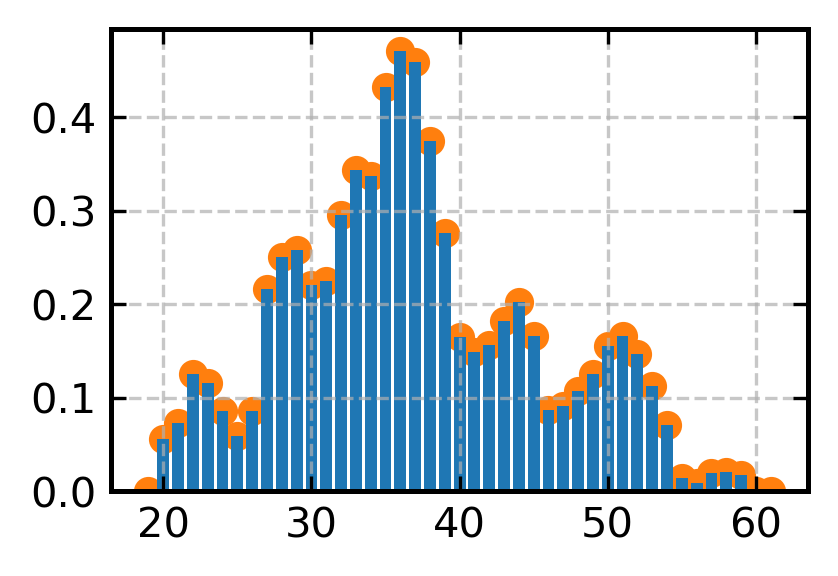

In [6]:
# sanity check that 2D map helix length vs residue correct and returns the same fraction helix per residue
df = pd.read_csv(output_path+f'{prod_name}_perres_helicity_300K.csv')
plt.figure(figsize = (3,2))
plt.bar(residues, prob_map[1:].sum(axis=0))
plt.scatter(df['Residue'], df['Fraction helix'])

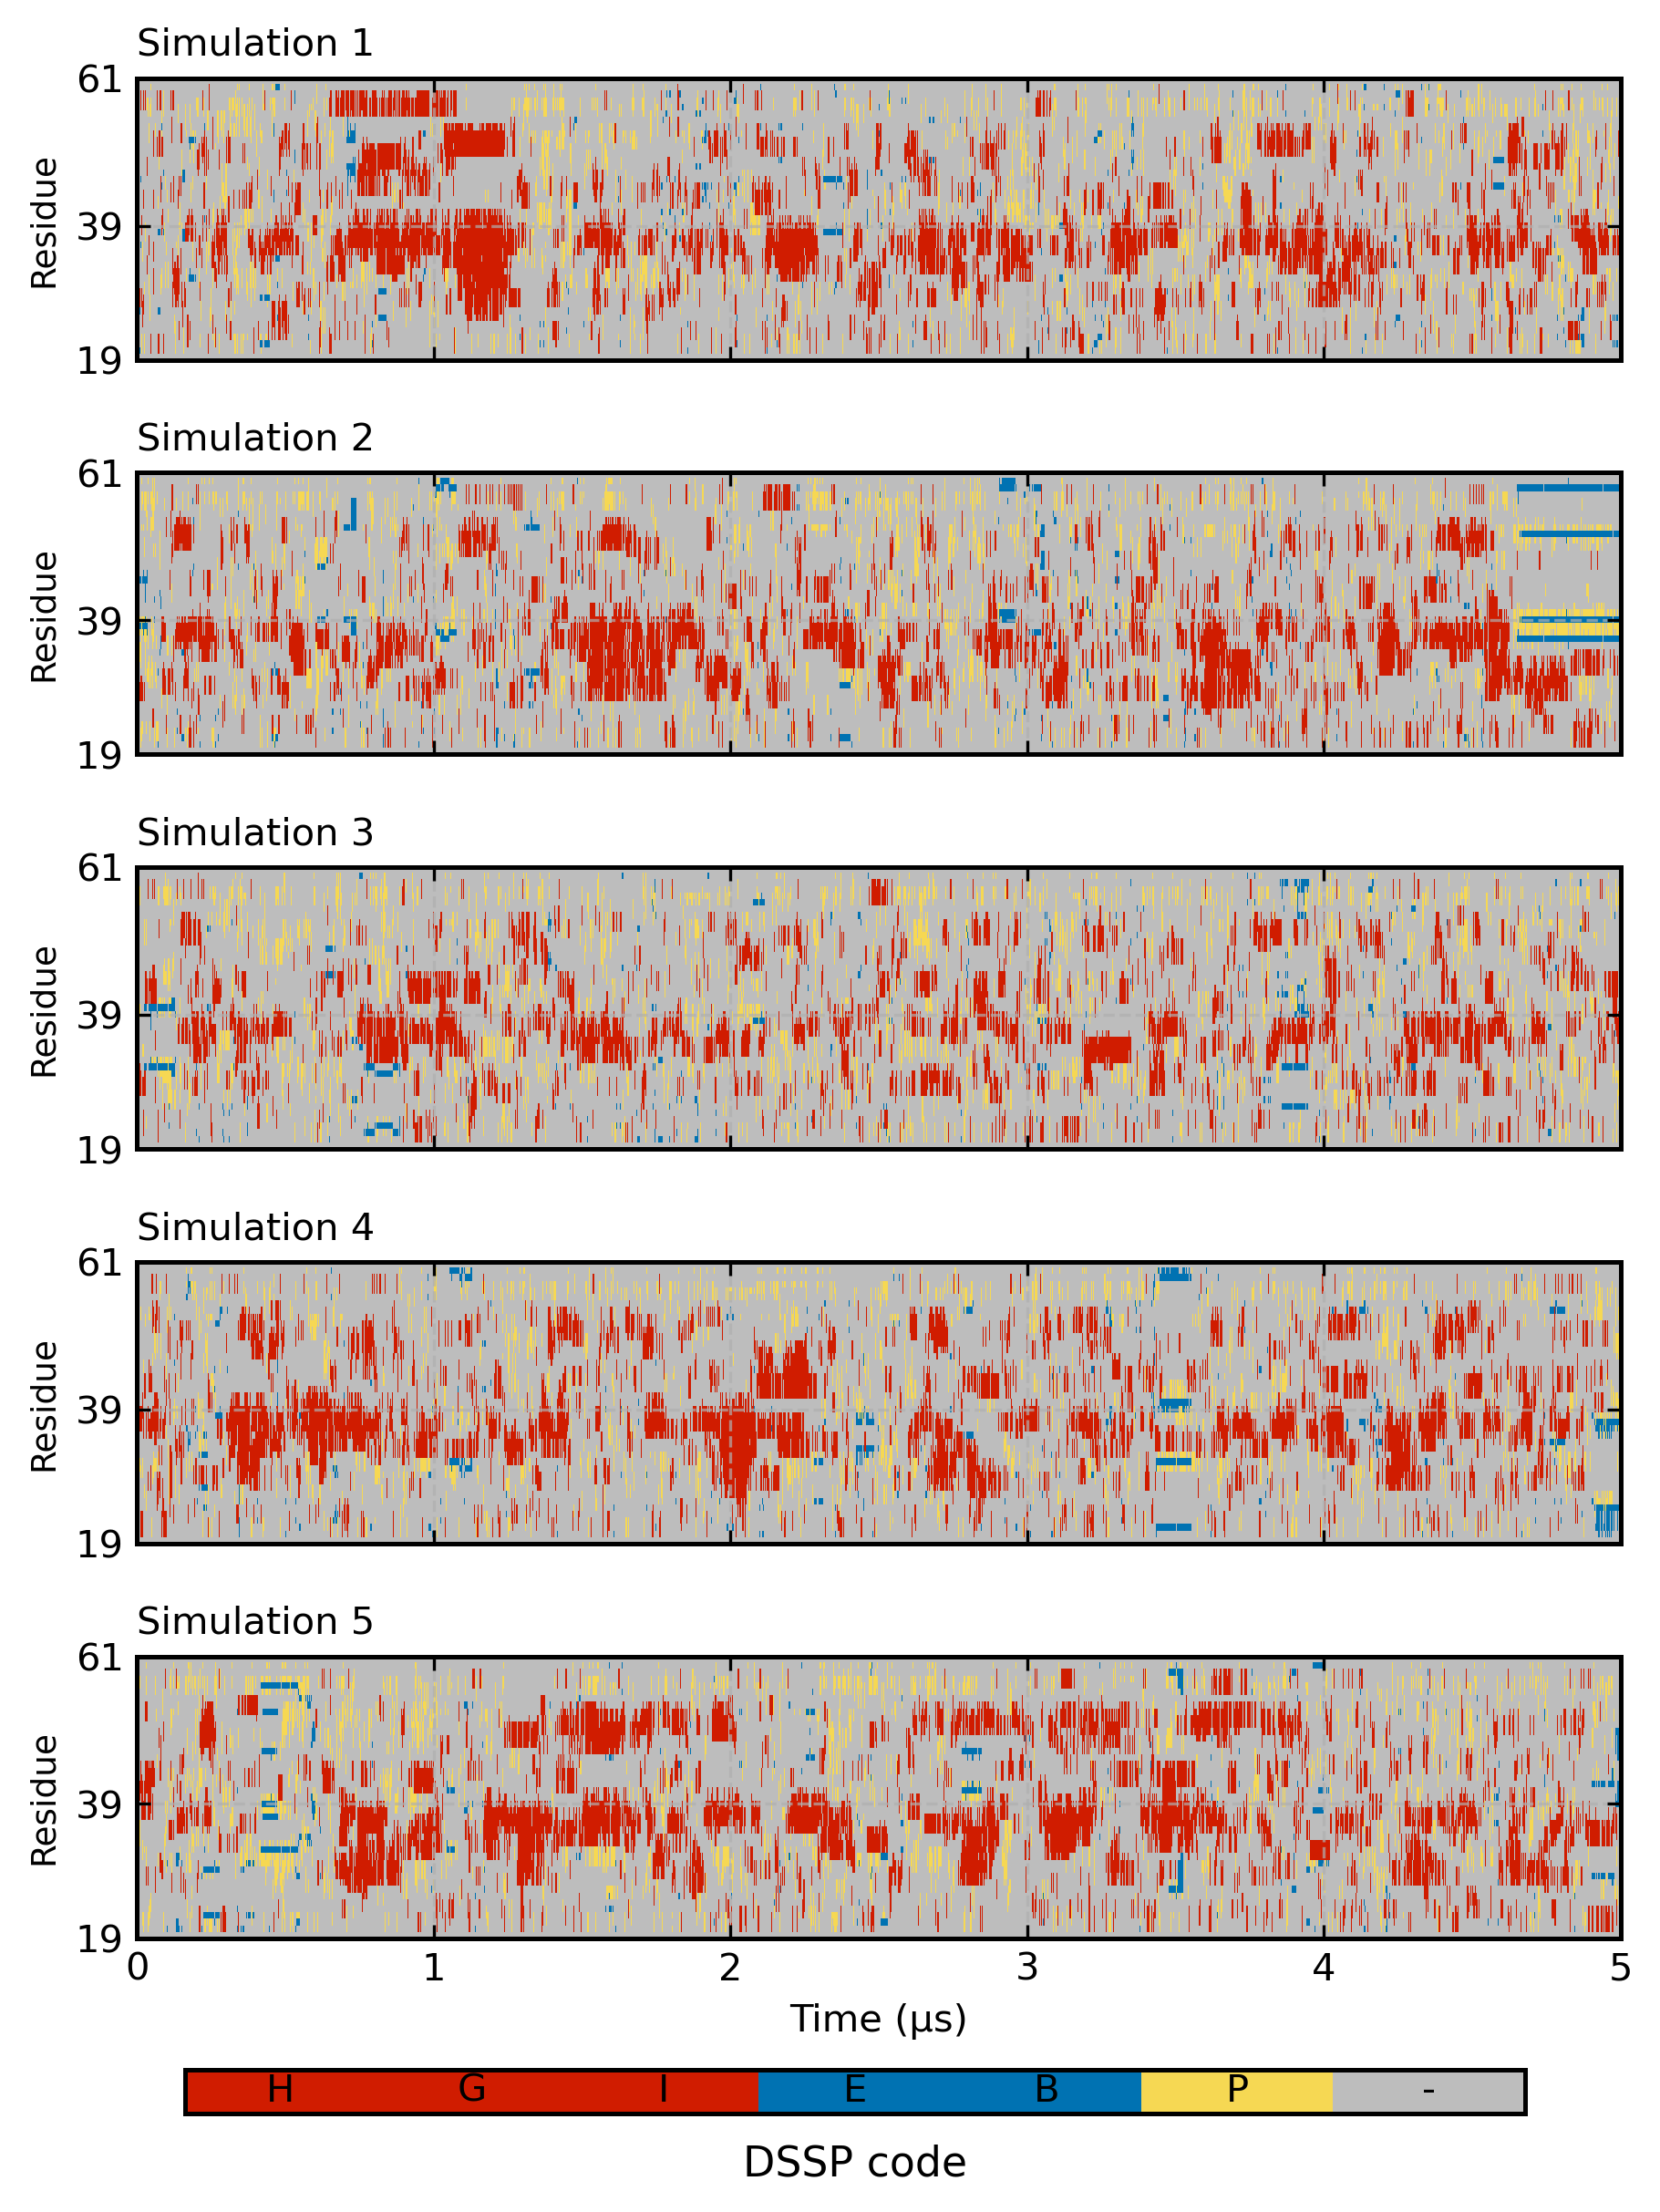

In [4]:
from matplotlib import gridspec
from matplotlib.colors import ListedColormap
nsims = 5

residue_offset = 18

# --- Figure setup: nreplica rows only, colorbar will be separate ---
fig_height = 0.8 * nsims + 4
fig = plt.figure(figsize=(7, fig_height))
gs = gridspec.GridSpec(nsims, 1, hspace=0.4)

# --- DSSP codes & colors ---
dssp_codes = ["H", "G", "I", "E", "B", "P","-"]
colors = [
    "#D01C00",  # H
    "#D01C00",  # G
    "#D01C00",  # I
    "#0072B2",  # E
    "#0072B2",  # B
    "#F6D853",  # P
    "#BDBDBD"   # -
]


# --- DSSP mapping ---
dssp_mapping = {
    'H': 0,  # α-helix
    'G': 1,  # 3_10 helix
    'I': 2,  # π-helix
    'E': 3,  # β-strand
    'B': 4,  # β-bridge
    'P': 5,  # PPII
    '-': 6,  # bend, turn 
    '-': 7  # coil
}

cmap = ListedColormap(colors)




# --- Plot each replica ---
axes = []
for i in range(nsims):
    ax = fig.add_subplot(gs[i, 0])
    axes.append(ax)
    with open(path + f'dssp{i}.dat') as f:
        dssp_lines = [line.strip() for line in f]
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    dssp_array = np.array([[dssp_mapping.get(c, 7) for c in line] for line in dssp_lines])[::10].T
    time_per_frame_ps = 10
    total_time_us = n_frames * time_per_frame_ps / 1e6
    im = ax.imshow(dssp_array, aspect='auto', origin='lower', cmap=cmap,
                   extent=[0, total_time_us, 1 + residue_offset, n_residues + residue_offset], interpolation='nearest', rasterized=True)
    ax.set_title(f"Simulation {i+1}", fontsize=10, loc="left")
    ax.set_ylabel("Residue", fontsize=9)
    ax.set_yticks([1 + residue_offset, n_residues//2 + residue_offset, n_residues + residue_offset])
    ax.set_ylim(1 + residue_offset, n_residues + residue_offset)
    ax.set_xlim(0, 5)
    if i < nsims - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Time (µs)", fontsize=10)

# --- Add colorbar *below* all axes ---
cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.02])  # [left, bottom, width, height]
cb = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cb.ax.tick_params(length=0)
cb.set_ticks([])

# Label each DSSP code directly in color patches
for idx, label in enumerate(dssp_codes):
    cb.ax.text((idx + 0.5) / len(colors), 0.5, label,
               ha='center', va='center', fontsize=10, color='black',
               transform=cb.ax.transAxes)

cb.set_label("DSSP code", fontsize=11, labelpad=8)

plt.subplots_adjust(bottom=0.12, top=0.97, hspace=0.4)
plt.savefig(output_path+f"{prod_name}_replicas_dssp_heatmap_colorbar_bottom.pdf",
            bbox_inches="tight")
